In [1]:
# ============================================================
# CELDA 00: Setup robusto (imports + pip sin !pip)
# ============================================================

import os
import sys
import textwrap
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_import(import_name: str, pip_name: str = None):
    try:
        return __import__(import_name)
    except Exception:
        pip_name = pip_name or import_name
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        return __import__(import_name)

pywt = _ensure_import("pywt", "PyWavelets")

try:
    from fpdf import FPDF
except Exception:
    _ensure_import("fpdf", "fpdf2")
    from fpdf import FPDF

try:
    from PIL import Image
except Exception:
    Image = None

print("OK: imports listos")
print("Python:", sys.version.split()[0])


OK: imports listos
Python: 3.11.9


In [2]:
# ============================================================
# CELDA 01: Resolver rutas + cargar parquet 4H
# ============================================================

def _is_colab():
    return (
        "COLAB_GPU" in os.environ
        or "COLAB_JUPYTER_IP" in os.environ
        or "google.colab" in sys.modules
        or (Path("/content").exists() and str(Path.cwd()).startswith(str(Path("/content"))))
    )

CWD = Path.cwd()

def _pick_project_root(cwd: Path) -> Path:
    if cwd.name.lower() in {"notebook", "notebooks"}:
        return cwd.parent
    parent = cwd.parent
    typical = {"data", "data_engine", "src", "notebooks"}
    if any((parent / t).exists() for t in typical) and not any((cwd / t).exists() for t in typical):
        return parent
    return cwd

PROJECT_ROOT = _pick_project_root(CWD).resolve()

PARQUET_FILENAME = "btc_4h_full.parquet"

def _find_exact_file_in_roots(roots, filename):
    typical_rel = [
        Path("data_engine") / filename,
        Path("data") / "processed" / filename,
        Path("data") / filename,
        Path("processed") / filename,
        Path(filename),
    ]
    for r in roots:
        r = Path(r).resolve()
        for rel in typical_rel:
            p = (r / rel)
            if p.exists():
                return p
    return None

roots_to_try = []
for r in [CWD, PROJECT_ROOT, PROJECT_ROOT.parent, PROJECT_ROOT.parent.parent]:
    if r not in roots_to_try:
        roots_to_try.append(r)

PARQUET_PATH = _find_exact_file_in_roots(roots_to_try, PARQUET_FILENAME)

REPORT_ROOT = (Path("/content/workshop_report") if _is_colab() else (PROJECT_ROOT / "workshop_report")).resolve()
FIG_DIR = (REPORT_ROOT / "figs").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
PDF_PATH = (REPORT_ROOT / "BTC_Workshop_Report.pdf").resolve()

print("==========================================")
print("DIAGNÓSTICO DE RUTAS")
print("==========================================")
print("CWD         :", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("PARQUET_PATH:", PARQUET_PATH)
print("REPORT_ROOT :", REPORT_ROOT)
print("FIG_DIR     :", FIG_DIR)
print("PDF_PATH    :", PDF_PATH)
print()

if PARQUET_PATH is None or not PARQUET_PATH.exists():
    raise FileNotFoundError(
        "No encuentro el parquet final 'btc_4h_full.parquet'.\n"
        "Colócalo en alguna de estas rutas típicas:\n"
        f"- {PROJECT_ROOT / 'data' / 'processed' / PARQUET_FILENAME}\n"
        f"- {PROJECT_ROOT / 'data_engine' / PARQUET_FILENAME}\n"
        f"- {PROJECT_ROOT / PARQUET_FILENAME}\n"
        "o ajusta tu Celda 02 de construcción para guardarlo ahí."
    )

df_4h = pd.read_parquet(str(PARQUET_PATH))
df_4h.columns = [c.lower().strip() for c in df_4h.columns]
df_4h["time"] = pd.to_datetime(df_4h["time"], errors="coerce")

needed = {"time", "open", "high", "low", "close"}
missing = needed - set(df_4h.columns)
if missing:
    raise ValueError(f"El parquet no contiene columnas requeridas: {missing}")

df_4h = df_4h.dropna(subset=list(needed))
df_4h = df_4h.sort_values("time").drop_duplicates(subset=["time"]).reset_index(drop=True)

print("OK: df_4h cargado")
print("Rango:", df_4h["time"].min(), "->", df_4h["time"].max())
print("Velas 4H:", len(df_4h))
print(df_4h.head(3))


DIAGNÓSTICO DE RUTAS
CWD         : c:\Quant\BTC_ANALIST\notebooks
PROJECT_ROOT: C:\Quant\BTC_ANALIST
PARQUET_PATH: C:\Quant\BTC_ANALIST\data\processed\btc_4h_full.parquet
REPORT_ROOT : C:\Quant\BTC_ANALIST\workshop_report
FIG_DIR     : C:\Quant\BTC_ANALIST\workshop_report\figs
PDF_PATH    : C:\Quant\BTC_ANALIST\workshop_report\BTC_Workshop_Report.pdf

OK: df_4h cargado
Rango: 2012-01-01 08:00:00 -> 2025-12-14 00:00:00
Velas 4H: 30575
                 time  open  high   low  close  volume
0 2012-01-01 08:00:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 12:00:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 16:00:00  4.58  4.58  4.58   4.58     0.0


In [3]:
# ============================================================
# CELDA 02: Halving calendar + epochs + sanity checks
# ============================================================

HALVING_DATES = {
    "h2012": pd.Timestamp("2012-11-28 00:00:00"),
    "h2016": pd.Timestamp("2016-07-09 00:00:00"),
    "h2020": pd.Timestamp("2020-05-11 00:00:00"),
    "h2024": pd.Timestamp("2024-04-20 00:00:00"),
}

def assign_halving_epoch(t):
    if t < HALVING_DATES["h2012"]:
        return "pre_2012_halving"
    elif t < HALVING_DATES["h2016"]:
        return "epoch_2012_2016"
    elif t < HALVING_DATES["h2020"]:
        return "epoch_2016_2020"
    elif t < HALVING_DATES["h2024"]:
        return "epoch_2020_2024"
    else:
        return "epoch_2024_present"

epoch_order = [
    "pre_2012_halving",
    "epoch_2012_2016",
    "epoch_2016_2020",
    "epoch_2020_2024",
    "epoch_2024_present",
]

EPOCH_TO_HALVING_EVENT = {
    "epoch_2012_2016": HALVING_DATES["h2012"],
    "epoch_2016_2020": HALVING_DATES["h2016"],
    "epoch_2020_2024": HALVING_DATES["h2020"],
    "epoch_2024_present": HALVING_DATES["h2024"],
    "pre_2012_halving": None,
}

HALVING_SEQUENCE = [
    HALVING_DATES["h2012"],
    HALVING_DATES["h2016"],
    HALVING_DATES["h2020"],
    HALVING_DATES["h2024"],
]

def next_halving_date(current_hd: pd.Timestamp):
    for i in range(len(HALVING_SEQUENCE) - 1):
        if HALVING_SEQUENCE[i] == current_hd:
            return HALVING_SEQUENCE[i + 1]
    return None

df_4h["halving_epoch"] = df_4h["time"].apply(assign_halving_epoch)

epoch_counts = df_4h["halving_epoch"].value_counts().reindex(epoch_order).fillna(0).astype(int)

print("Conteo por epoch:")
print(epoch_counts.to_string())
print()

# Sanity: monotonic time
is_sorted = df_4h["time"].is_monotonic_increasing
print("Time monotonic:", is_sorted)

# Sanity: gaps grandes (opcional)
dt = df_4h["time"].diff().dropna()
print("Delta mediana:", dt.median())
print("Delta max    :", dt.max())


Conteo por epoch:
halving_epoch
pre_2012_halving      1990
epoch_2012_2016       7914
epoch_2016_2020       8412
epoch_2020_2024       8640
epoch_2024_present    3619

Time monotonic: True
Delta mediana: 0 days 04:00:00
Delta max    : 0 days 04:00:00


In [4]:
# ============================================================
# CELDA 03: Estadística de ciclo (LOW/HIGH reales) + histogramas
# ============================================================

stats_cycle_rows = []
price_hist_files = []

for ep in epoch_order:
    sub = df_4h[df_4h["halving_epoch"] == ep]
    if sub.empty:
        continue

    closes = sub["close"].astype(float)
    lows   = sub["low"].astype(float)
    highs  = sub["high"].astype(float)

    stats_cycle_rows.append({
        "halving_epoch": ep,
        "data_start": sub["time"].min(),
        "data_end": sub["time"].max(),
        "candles_4h": int(len(sub)),
        "mean_close": float(closes.mean()),
        "median_close": float(closes.median()),
        "std_close": float(closes.std()),
        "min_close_epoch": float(closes.min()),
        "max_close_epoch": float(closes.max()),
        "min_low_epoch": float(lows.min()),
        "max_high_epoch": float(highs.max()),
    })

    # Histograma de precio (Close)
    fig_path = FIG_DIR / f"hist_close_{ep}.png"
    plt.figure(figsize=(10, 4))
    plt.hist(closes.values, bins="auto")
    plt.title(
        f"Distribución Close BTC 4H | {ep}\n"
        f"{sub['time'].min()} -> {sub['time'].max()} | Velas: {len(sub):,}"
    )
    plt.xlabel("Close (USD)")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    price_hist_files.append(str(fig_path))

stats_cycle = pd.DataFrame(stats_cycle_rows)
print("OK: tabla stats_cycle")
print(stats_cycle.to_string(index=False))
print("\nEjemplo figuras:", price_hist_files[:2])


OK: tabla stats_cycle
     halving_epoch          data_start            data_end  candles_4h   mean_close  median_close    std_close  min_close_epoch  max_close_epoch  min_low_epoch  max_high_epoch
  pre_2012_halving 2012-01-01 08:00:00 2012-11-27 20:00:00        1990     7.741894          6.52     2.848190             4.17            15.00           3.80           16.41
   epoch_2012_2016 2012-11-28 00:00:00 2016-07-08 20:00:00        7914   340.430662        318.98   215.864963            12.03          1151.00          11.90         1163.00
   epoch_2016_2020 2016-07-09 00:00:00 2020-05-10 20:00:00        8412  5740.426794       6315.60  3690.377039           540.00         19494.73         465.28        19666.00
   epoch_2020_2024 2020-05-11 00:00:00 2024-04-19 20:00:00        8640 32800.417020      29946.00 15546.067147          8571.98         73468.00        8181.00        73794.00
epoch_2024_present 2024-04-20 00:00:00 2025-12-14 00:00:00        3619 88731.127936      93381.00 

In [5]:
# ============================================================
# CELDA 04: Event Study Halving (PRE/POST, retornos, peaks, drawdowns)
# ============================================================

PEAK_WINDOW_DAYS = 540  # estándar comparativo cross-cycle (ajustable)

def bar_at_or_after(df: pd.DataFrame, t0: pd.Timestamp):
    w = df[df["time"] >= t0]
    return None if w.empty else w.iloc[0]

def window_slice(df: pd.DataFrame, t0: pd.Timestamp, days: int, mode: str):
    # mode="post": [t0, t0+days]
    # mode="pre" : [t0-days, t0]
    if mode == "post":
        t1 = t0 + pd.Timedelta(days=days)
        return df[(df["time"] >= t0) & (df["time"] <= t1)]
    elif mode == "pre":
        t1 = t0 - pd.Timedelta(days=days)
        return df[(df["time"] >= t1) & (df["time"] <= t0)]
    else:
        raise ValueError("mode debe ser 'pre' o 'post'")

def minmax_lowhigh(w: pd.DataFrame):
    if w.empty:
        return np.nan, np.nan
    return float(w["low"].astype(float).min()), float(w["high"].astype(float).max())

def close_at_horizon(df: pd.DataFrame, t0: pd.Timestamp, days: int):
    # close de la primera vela en/tras t0+days
    tgt = t0 + pd.Timedelta(days=days)
    b = bar_at_or_after(df, tgt)
    return (np.nan, pd.NaT) if b is None else (float(b["close"]), pd.Timestamp(b["time"]))

def mdd_low_vs_peakclose(df: pd.DataFrame):
    # conservador: trough=LOW, peak=running max CLOSE
    if df.empty:
        return np.nan
    close = df["close"].astype(float).values
    low = df["low"].astype(float).values
    peak = np.maximum.accumulate(close)
    dd = (low / peak) - 1.0
    return float(np.min(dd))

def mdd_low_vs_peakhigh(df: pd.DataFrame):
    # estándar: trough=LOW, peak=running max HIGH
    if df.empty:
        return np.nan
    high = df["high"].astype(float).values
    low = df["low"].astype(float).values
    peak = np.maximum.accumulate(high)
    dd = (low / peak) - 1.0
    return float(np.min(dd))

def peak_to_trough_after_global_peak(df: pd.DataFrame):
    # Peak global HIGH dentro del window; luego trough LOW posterior
    if df.empty:
        return np.nan, pd.NaT, np.nan, pd.NaT
    high = df["high"].astype(float)
    low = df["low"].astype(float)
    idx_peak = high.idxmax()
    t_peak = pd.Timestamp(df.loc[idx_peak, "time"])
    peak_val = float(high.loc[idx_peak])

    df_after = df.loc[idx_peak:]
    if df_after.empty:
        return np.nan, t_peak, np.nan, pd.NaT

    idx_trough = df_after["low"].astype(float).idxmin()
    t_trough = pd.Timestamp(df_after.loc[idx_trough, "time"])
    trough_val = float(df_after.loc[idx_trough, "low"])

    dd = (trough_val / peak_val) - 1.0
    return float(dd), t_peak, float(trough_val), t_trough

event_rows = []

for ep in epoch_order:
    halving_dt = EPOCH_TO_HALVING_EVENT.get(ep, None)
    if halving_dt is None:
        # sin evento para pre_2012_halving (por cobertura)
        event_rows.append({
            "halving_epoch": ep,
            "halving_event_time": pd.NaT,
        })
        continue

    # Bar post-halving (4H)
    b0 = bar_at_or_after(df_4h, halving_dt)
    if b0 is None:
        event_rows.append({"halving_epoch": ep, "halving_event_time": halving_dt})
        continue

    close0 = float(b0["close"])
    time0 = pd.Timestamp(b0["time"])

    # Ventanas PRE
    pre30  = window_slice(df_4h, halving_dt, 30,  "pre")
    pre90  = window_slice(df_4h, halving_dt, 90,  "pre")
    pre180 = window_slice(df_4h, halving_dt, 180, "pre")
    pre30_min,  pre30_max  = minmax_lowhigh(pre30)
    pre90_min,  pre90_max  = minmax_lowhigh(pre90)
    pre180_min, pre180_max = minmax_lowhigh(pre180)

    # Ventanas POST
    post30  = window_slice(df_4h, halving_dt, 30,  "post")
    post90  = window_slice(df_4h, halving_dt, 90,  "post")
    post180 = window_slice(df_4h, halving_dt, 180, "post")
    post30_min,  post30_max  = minmax_lowhigh(post30)
    post90_min,  post90_max  = minmax_lowhigh(post90)
    post180_min, post180_max = minmax_lowhigh(post180)

    # Retornos a horizontes (Close)
    c30,  t30  = close_at_horizon(df_4h, halving_dt, 30)
    c90,  t90  = close_at_horizon(df_4h, halving_dt, 90)
    c180, t180 = close_at_horizon(df_4h, halving_dt, 180)

    ret30  = (c30  / close0 - 1.0) if np.isfinite(c30)  else np.nan
    ret90  = (c90  / close0 - 1.0) if np.isfinite(c90)  else np.nan
    ret180 = (c180 / close0 - 1.0) if np.isfinite(c180) else np.nan

    # Window hasta siguiente halving (o fin)
    next_hd = next_halving_date(halving_dt)
    if next_hd is None:
        w_until_next = df_4h[df_4h["time"] >= halving_dt]
    else:
        w_until_next = df_4h[(df_4h["time"] >= halving_dt) & (df_4h["time"] < next_hd)]

    # Peak HIGH hasta next halving
    if w_until_next.empty:
        peak_next = np.nan
        t_peak_next = pd.NaT
        ttm_next_days = np.nan
    else:
        idx = w_until_next["high"].astype(float).idxmax()
        peak_next = float(w_until_next.loc[idx, "high"])
        t_peak_next = pd.Timestamp(w_until_next.loc[idx, "time"])
        ttm_next_days = float((t_peak_next - halving_dt).total_seconds() / 86400.0)

    ret_to_peak_next = (peak_next / close0 - 1.0) if np.isfinite(peak_next) else np.nan

    # Peak HIGH en ventana estandarizada (540d)
    w_540 = window_slice(df_4h, halving_dt, PEAK_WINDOW_DAYS, "post")
    if w_540.empty:
        peak_540 = np.nan
        t_peak_540 = pd.NaT
        ttm_540_days = np.nan
    else:
        idx = w_540["high"].astype(float).idxmax()
        peak_540 = float(w_540.loc[idx, "high"])
        t_peak_540 = pd.Timestamp(w_540.loc[idx, "time"])
        ttm_540_days = float((t_peak_540 - halving_dt).total_seconds() / 86400.0)

    ret_to_peak_540 = (peak_540 / close0 - 1.0) if np.isfinite(peak_540) else np.nan

    # Drawdowns (post-halving hasta next)
    mdd_cons = mdd_low_vs_peakclose(w_until_next)
    mdd_std  = mdd_low_vs_peakhigh(w_until_next)
    dd_peak2trough, t_peak_global, trough_val, t_trough = peak_to_trough_after_global_peak(w_until_next)

    event_rows.append({
        "halving_epoch": ep,
        "halving_event_time": halving_dt,
        "time_at_halving_post4h": time0,
        "close_at_halving_post4h": close0,

        # PRE windows
        "min_low_30d_pre": pre30_min,   "max_high_30d_pre": pre30_max,
        "min_low_90d_pre": pre90_min,   "max_high_90d_pre": pre90_max,
        "min_low_180d_pre": pre180_min, "max_high_180d_pre": pre180_max,

        # POST windows
        "min_low_30d_post": post30_min,   "max_high_30d_post": post30_max,
        "min_low_90d_post": post90_min,   "max_high_90d_post": post90_max,
        "min_low_180d_post": post180_min, "max_high_180d_post": post180_max,

        # Performance post
        "close_30d": c30, "time_30d": t30, "ret_30d": ret30,
        "close_90d": c90, "time_90d": t90, "ret_90d": ret90,
        "close_180d": c180, "time_180d": t180, "ret_180d": ret180,

        # Peaks
        "max_high_until_next_halving": peak_next,
        "time_of_max_high_until_next": t_peak_next,
        "time_to_max_high_until_next_days": ttm_next_days,
        "ret_to_peak_until_next": ret_to_peak_next,

        f"max_high_within_{PEAK_WINDOW_DAYS}d": peak_540,
        f"time_of_max_high_within_{PEAK_WINDOW_DAYS}d": t_peak_540,
        f"time_to_max_high_within_{PEAK_WINDOW_DAYS}d_days": ttm_540_days,
        f"ret_to_peak_within_{PEAK_WINDOW_DAYS}d": ret_to_peak_540,

        # Drawdowns
        "mdd_conservative_low_vs_peakclose": mdd_cons,
        "mdd_standard_low_vs_peakhigh": mdd_std,
        "dd_peak_to_trough_after_global_peak": dd_peak2trough,
        "time_of_global_peak_high": t_peak_global,
        "trough_low_after_peak": trough_val,
        "time_of_trough_after_peak": t_trough,
    })

event_study = pd.DataFrame(event_rows)

print("OK: tabla event_study (evento halving + pre/post/performance/peaks/drawdowns)")
print(event_study.head(10).to_string(index=False))


OK: tabla event_study (evento halving + pre/post/performance/peaks/drawdowns)
     halving_epoch halving_event_time time_at_halving_post4h  close_at_halving_post4h  min_low_30d_pre  max_high_30d_pre  min_low_90d_pre  max_high_90d_pre  min_low_180d_pre  max_high_180d_pre  min_low_30d_post  max_high_30d_post  min_low_90d_post  max_high_90d_post  min_low_180d_post  max_high_180d_post  close_30d   time_30d   ret_30d  close_90d   time_90d   ret_90d  close_180d  time_180d  ret_180d  max_high_until_next_halving time_of_max_high_until_next  time_to_max_high_until_next_days  ret_to_peak_until_next  max_high_within_540d time_of_max_high_within_540d  time_to_max_high_within_540d_days  ret_to_peak_within_540d  mdd_conservative_low_vs_peakclose  mdd_standard_low_vs_peakhigh  dd_peak_to_trough_after_global_peak time_of_global_peak_high  trough_low_after_peak time_of_trough_after_peak
  pre_2012_halving                NaT                    NaT                      NaN              NaN               

In [6]:
# ============================================================
# CELDA 05: Riesgo (log-retornos 4H) VaR/ES + histogramas
# ============================================================

def annualized_vol_from_4h_log_returns(lr: pd.Series) -> float:
    lr = lr.dropna()
    if lr.empty:
        return np.nan
    return float(lr.std() * np.sqrt(6 * 365.25))

def var_es(lr: pd.Series, alpha: float):
    x = lr.dropna().values
    if len(x) == 0:
        return np.nan, np.nan
    q = np.quantile(x, alpha)
    tail = x[x <= q]
    es = tail.mean() if len(tail) else np.nan
    return float(q), float(es)

returns_rows = []
ret_hist_files = []

for ep in epoch_order:
    sub = df_4h[df_4h["halving_epoch"] == ep].copy()
    if sub.empty:
        continue

    sub = sub.sort_values("time")
    lr = np.log(sub["close"].astype(float)).diff().dropna()

    vol_ann = annualized_vol_from_4h_log_returns(lr)
    var95, es95 = var_es(lr, 0.05)
    var99, es99 = var_es(lr, 0.01)

    returns_rows.append({
        "halving_epoch": ep,
        "epoch_start": sub["time"].min(),
        "epoch_end": sub["time"].max(),
        "candles_4h": int(len(sub)),
        "n_log_returns": int(lr.size),
        "mean_lr_4h": float(lr.mean()) if lr.size else np.nan,
        "median_lr_4h": float(lr.median()) if lr.size else np.nan,
        "std_lr_4h": float(lr.std()) if lr.size else np.nan,
        "vol_annualized": vol_ann,
        "VaR95_lr": var95, "ES95_lr": es95,
        "VaR99_lr": var99, "ES99_lr": es99,
    })

    fig_path = FIG_DIR / f"hist_logret_{ep}.png"
    plt.figure(figsize=(10, 4))
    plt.hist(lr.values, bins="auto")
    plt.title(
        f"BTC 4H - Distribución LOG-RETORNOS | {ep}\n"
        f"{sub['time'].min()} -> {sub['time'].max()} | N: {lr.size:,}"
    )
    plt.xlabel("Log-retorno 4H")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    ret_hist_files.append(str(fig_path))

returns_summary_epoch = pd.DataFrame(returns_rows)
print("OK: returns_summary_epoch")
print(returns_summary_epoch.to_string(index=False))


OK: returns_summary_epoch
     halving_epoch         epoch_start           epoch_end  candles_4h  n_log_returns  mean_lr_4h  median_lr_4h  std_lr_4h  vol_annualized  VaR95_lr   ES95_lr  VaR99_lr   ES99_lr
  pre_2012_halving 2012-01-01 08:00:00 2012-11-27 20:00:00        1990           1989    0.000482      0.000000   0.023435        1.097082 -0.029443 -0.059015 -0.071999 -0.114972
   epoch_2012_2016 2012-11-28 00:00:00 2016-07-08 20:00:00        7914           7913    0.000505      0.000379   0.024298        1.137465 -0.023878 -0.053507 -0.059497 -0.124735
   epoch_2016_2020 2016-07-09 00:00:00 2020-05-10 20:00:00        8412           8411    0.000303      0.000334   0.017522        0.820277 -0.026017 -0.044733 -0.053107 -0.077498
   epoch_2020_2024 2020-05-11 00:00:00 2024-04-19 20:00:00        8640           8639    0.000231      0.000219   0.013492        0.631611 -0.020589 -0.033487 -0.041774 -0.056515
epoch_2024_present 2024-04-20 00:00:00 2025-12-14 00:00:00        3619         

In [7]:
# ============================================================
# CELDA 06: DWT en precios (régimen) + figuras
# ============================================================

BASE_HOURS = 4
WAVELET_NAME = "db4"
wavelet = pywt.Wavelet(WAVELET_NAME)

def level_horizon_days(level: int, base_hours: int = 4) -> float:
    return ((2 ** level) * base_hours) / 24.0

def compute_dwt_energy(log_prices: np.ndarray, wavelet_obj):
    max_level = pywt.dwt_max_level(len(log_prices), wavelet_obj.dec_len)
    level = min(max_level, 9) if max_level > 0 else 1
    coeffs = pywt.wavedec(log_prices, wavelet_obj, level=level)
    details = coeffs[1:][::-1]
    energies = {f"D{i}": float(np.sum(np.square(cD))) for i, cD in enumerate(details, start=1)}
    total_e = float(sum(energies.values()))
    return level, energies, total_e, coeffs

def reconstruct_approx_only(coeffs, wavelet_obj):
    cA = coeffs[0]
    zeros = [np.zeros_like(c) for c in coeffs[1:]]
    return pywt.waverec([cA] + zeros, wavelet_obj)

price_vs_trend_files = []
price_dwt_energy_files = []
wavelet_price_rows = []

for ep in epoch_order:
    sub = df_4h[df_4h["halving_epoch"] == ep].copy()
    if sub.empty:
        continue

    sub = sub.sort_values("time")
    closes = sub["close"].astype(float).values
    times  = sub["time"].values

    log_prices = np.log(closes)
    level, energies, total_e, coeffs = compute_dwt_energy(log_prices, wavelet)

    # tabla energía (precio)
    for k, v in energies.items():
        lvl = int(k.replace("D",""))
        wavelet_price_rows.append({
            "halving_epoch": ep,
            "detail_level": k,
            "level_num": lvl,
            "approx_horizon_days": level_horizon_days(lvl, BASE_HOURS),
            "energy_pct_of_details": (v/total_e*100) if total_e > 0 else np.nan,
            "dwt_level_used": int(level),
        })

    # precio vs tendencia
    approx_log = reconstruct_approx_only(coeffs, wavelet)
    m = min(len(approx_log), len(log_prices))
    approx_close = np.exp(approx_log[:m])

    fig_path = FIG_DIR / f"price_vs_trend_{ep}.png"
    plt.figure(figsize=(11, 4))
    plt.plot(times[:m], closes[:m], label="Close 4H")
    plt.plot(times[:m], approx_close, label=f"Aprox DWT (nivel {level})")
    plt.title(f"BTC 4H - Precio vs Tendencia Suavizada (DWT) | {ep}")
    plt.xlabel("Tiempo")
    plt.ylabel("Precio (USD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    price_vs_trend_files.append(str(fig_path))

    # energía por escala
    levels_sorted = sorted(energies.keys(), key=lambda s: int(s.replace("D","")))
    pcts = [(energies[l]/total_e*100) if total_e > 0 else 0.0 for l in levels_sorted]
    horizons = [level_horizon_days(int(l.replace("D","")), BASE_HOURS) for l in levels_sorted]

    fig_path = FIG_DIR / f"energy_price_{ep}.png"
    plt.figure(figsize=(11, 4))
    plt.bar([f"{l}\n~{h:.0f}d" for l, h in zip(levels_sorted, horizons)], pcts)
    plt.title(f"BTC 4H - Energía DWT por Escala (Precio) | {ep}")
    plt.xlabel("Nivel (escala aprox)")
    plt.ylabel("% Energía de detalles")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    price_dwt_energy_files.append(str(fig_path))

wavelet_energy_table_price = pd.DataFrame(wavelet_price_rows)
print("OK: wavelet_energy_table_price")
print(wavelet_energy_table_price.head(10).to_string(index=False))


OK: wavelet_energy_table_price
   halving_epoch detail_level  level_num  approx_horizon_days  energy_pct_of_details  dwt_level_used
pre_2012_halving           D1          1             0.333333               1.982002               8
pre_2012_halving           D2          2             0.666667               2.127347               8
pre_2012_halving           D3          3             1.333333               3.359633               8
pre_2012_halving           D4          4             2.666667               4.828753               8
pre_2012_halving           D5          5             5.333333               8.466385               8
pre_2012_halving           D6          6            10.666667              17.743632               8
pre_2012_halving           D7          7            21.333333              19.625331               8
pre_2012_halving           D8          8            42.666667              41.866917               8
 epoch_2012_2016           D1          1             0.33333

In [8]:
# ============================================================
# CELDA 07: DWT en log-retornos + buckets + figuras
# ============================================================

SHORT_LEVELS = {1,2,3}
MED_LEVELS = {4,5,6}

wavelet_ret_rows = []
bucket_rows = []
ret_energy_files = []
bucket_energy_files = []

for ep in epoch_order:
    sub = df_4h[df_4h["halving_epoch"] == ep].copy()
    if sub.empty:
        continue

    lr = np.log(sub["close"].astype(float)).diff().dropna()
    if lr.size < 128:
        continue

    lr_array = lr.values
    max_level = pywt.dwt_max_level(len(lr_array), wavelet.dec_len)
    level = min(max_level, 9) if max_level > 0 else 1

    coeffs = pywt.wavedec(lr_array, wavelet, level=level)
    details = coeffs[1:][::-1]  # D1..Dn
    energies = {f"D{i}": float(np.sum(np.square(cD))) for i, cD in enumerate(details, start=1)}
    total_e = float(sum(energies.values()))

    for k, v in energies.items():
        lvl = int(k.replace("D",""))
        wavelet_ret_rows.append({
            "halving_epoch": ep,
            "detail_level": k,
            "level_num": lvl,
            "approx_horizon_days": level_horizon_days(lvl, BASE_HOURS),
            "energy_pct_of_details": (v/total_e*100) if total_e > 0 else np.nan,
            "dwt_level_used": int(level),
        })

    available_levels = set(range(1, level + 1))
    long_levels = {l for l in available_levels if l >= 7}

    short_e = sum(v for k, v in energies.items() if int(k.replace("D","")) in SHORT_LEVELS)
    med_e   = sum(v for k, v in energies.items() if int(k.replace("D","")) in MED_LEVELS)
    long_e  = sum(v for k, v in energies.items() if int(k.replace("D","")) in long_levels)
    total_b = short_e + med_e + long_e

    bucket_rows.append({
        "halving_epoch": ep,
        "short_energy_pct": (short_e/total_b*100) if total_b > 0 else np.nan,
        "medium_energy_pct": (med_e/total_b*100) if total_b > 0 else np.nan,
        "long_energy_pct": (long_e/total_b*100) if total_b > 0 else np.nan,
        "dwt_level_used": int(level),
    })

    # Figura energía por nivel (retornos)
    levels_sorted = sorted(energies.keys(), key=lambda s: int(s.replace("D","")))
    pcts = [(energies[l]/total_e*100) if total_e > 0 else 0 for l in levels_sorted]
    horizons = [level_horizon_days(int(l.replace("D","")), BASE_HOURS) for l in levels_sorted]

    fig_path = FIG_DIR / f"energy_logret_{ep}.png"
    plt.figure(figsize=(11, 4))
    plt.bar([f"{l}\n~{h:.0f}d" for l, h in zip(levels_sorted, horizons)], pcts)
    plt.title(f"BTC 4H - Energía DWT por Escala (LOG-RET) | {ep}")
    plt.xlabel("Nivel (escala aprox)")
    plt.ylabel("% Energía de detalles")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    ret_energy_files.append(str(fig_path))

    # Figura buckets
    last_bucket = bucket_rows[-1]
    fig_path = FIG_DIR / f"bucket_energy_{ep}.png"
    plt.figure(figsize=(6, 4))
    plt.bar(
        ["Corto\n(D1-D3)", "Medio\n(D4-D6)", "Largo\n(D7+)"],
        [last_bucket["short_energy_pct"], last_bucket["medium_energy_pct"], last_bucket["long_energy_pct"]]
    )
    plt.title(f"BTC 4H - Energía por Horizonte (LOG-RET) | {ep}")
    plt.xlabel("Bucket")
    plt.ylabel("% Energía de detalles")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()
    bucket_energy_files.append(str(fig_path))

wavelet_energy_table_ret = pd.DataFrame(wavelet_ret_rows)
bucket_energy_summary = pd.DataFrame(bucket_rows)

print("OK: wavelet_energy_table_ret + bucket_energy_summary")
print(bucket_energy_summary.to_string(index=False))


OK: wavelet_energy_table_ret + bucket_energy_summary
     halving_epoch  short_energy_pct  medium_energy_pct  long_energy_pct  dwt_level_used
  pre_2012_halving         92.686384           6.368378         0.945238               8
   epoch_2012_2016         87.756657          11.077574         1.165769               9
   epoch_2016_2020         85.701577          11.019627         3.278796               9
   epoch_2020_2024         87.598900          10.830707         1.570393               9
epoch_2024_present         88.863635           9.862246         1.274119               9


In [9]:
# ============================================================
# CELDA 08: Consolidación (tablas maestras)
# ============================================================

# Merge recomendado: ciclo + evento + riesgo
master = stats_cycle.merge(event_study, on="halving_epoch", how="left")
master = master.merge(returns_summary_epoch, on="halving_epoch", how="left", suffixes=("", "_risk"))

# Orden estable
master["halving_epoch"] = pd.Categorical(master["halving_epoch"], categories=epoch_order, ordered=True)
master = master.sort_values("halving_epoch").reset_index(drop=True)

# Guardado opcional (útil para auditoría)
out_master = REPORT_ROOT / "master_cycle_event_risk.csv"
master.to_csv(out_master, index=False)

print("OK: MASTER TABLE")
print("Guardado:", out_master)
print(master.head(5).to_string(index=False))


OK: MASTER TABLE
Guardado: C:\Quant\BTC_ANALIST\workshop_report\master_cycle_event_risk.csv
     halving_epoch          data_start            data_end  candles_4h   mean_close  median_close    std_close  min_close_epoch  max_close_epoch  min_low_epoch  max_high_epoch halving_event_time time_at_halving_post4h  close_at_halving_post4h  min_low_30d_pre  max_high_30d_pre  min_low_90d_pre  max_high_90d_pre  min_low_180d_pre  max_high_180d_pre  min_low_30d_post  max_high_30d_post  min_low_90d_post  max_high_90d_post  min_low_180d_post  max_high_180d_post  close_30d   time_30d   ret_30d  close_90d   time_90d   ret_90d  close_180d  time_180d  ret_180d  max_high_until_next_halving time_of_max_high_until_next  time_to_max_high_until_next_days  ret_to_peak_until_next  max_high_within_540d time_of_max_high_within_540d  time_to_max_high_within_540d_days  ret_to_peak_within_540d  mdd_conservative_low_vs_peakclose  mdd_standard_low_vs_peakhigh  dd_peak_to_trough_after_global_peak time_of_global_peak_

In [10]:
# ============================================================
# CELDA 09: PDF FINAL (regenera desde parquet + incluye TODO)
# ============================================================

def _sanitize_for_fpdf(s: str) -> str:
    s = s.replace("→", "->").replace("–", "-").replace("—", "-")
    return s.encode("latin-1", "replace").decode("latin-1")

class ReportPDF(FPDF):
    def header(self):
        self.set_font("Helvetica", "B", 12)
        self.cell(0, 8, "BTC 4H Workshop Report", align="C")
        self.ln(6)

    def footer(self):
        self.set_y(-12)
        self.set_font("Helvetica", "", 9)
        self.cell(0, 8, f"Página {self.page_no()}", align="C")

def _safe_multicell(pdf, w, h, txt):
    try:
        pdf.multi_cell(w, h, txt, new_x="LMARGIN", new_y="NEXT")
    except TypeError:
        pdf.multi_cell(w, h, txt)

def safe_write_block(pdf, title, body, wrap_width=110):
    title = _sanitize_for_fpdf(title)
    body = _sanitize_for_fpdf(body)

    pdf.set_font("Helvetica", "B", 12)
    _safe_multicell(pdf, 0, 6, title)
    pdf.ln(1)

    pdf.set_font("Helvetica", "", 10)
    lines = []
    for raw_line in body.splitlines():
        line = raw_line.rstrip()
        if not line:
            lines.append("")
            continue
        wrapped = textwrap.fill(line, width=wrap_width, break_long_words=True, break_on_hyphens=False)
        lines.extend(wrapped.splitlines())

    for line in lines:
        _safe_multicell(pdf, 0, 5, line)
    pdf.ln(2)

def add_image(pdf, img_path, w_mm=180):
    if not os.path.exists(img_path):
        return
    if Image is not None:
        try:
            with Image.open(img_path) as im:
                px_w, px_h = im.size
            h_mm = w_mm * (px_h / px_w)
            if pdf.get_y() + h_mm + 10 > pdf.page_break_trigger:
                pdf.add_page()
        except Exception:
            pass
    pdf.image(img_path, w=w_mm)
    pdf.ln(4)

def section_images(pdf, title, files, w_mm=180):
    if not files:
        return
    pdf.add_page()
    pdf.set_font("Helvetica", "B", 12)
    _safe_multicell(pdf, 0, 6, _sanitize_for_fpdf(title))
    pdf.ln(2)
    for f in files:
        add_image(pdf, f, w_mm=w_mm)

# Textos
t0 = df_4h["time"].min()
t1 = df_4h["time"].max()
years = (t1 - t0).days / 365.25 if pd.notna(t0) and pd.notna(t1) else 0

intro_text = f"""
REPORTE CONSOLIDADO DEL TALLER: BTC 4H

Cobertura:
- Inicio: {t0}
- Fin:    {t1}
- Años aprox: {years:.2f}
- Total velas 4H: {len(df_4h):,}

Incluye mejoras cuantitativas:
- Extremos reales por ciclo: min LOW / max HIGH.
- Event study Halving:
  * Ventanas PRE: -30/-90/-180 dias (LOW/HIGH).
  * Ventanas POST: +30/+90/+180 dias (LOW/HIGH).
  * Retornos: +30/+90/+180 (Close).
  * Peaks: hasta siguiente Halving y ventana estandar {PEAK_WINDOW_DAYS} dias.
  * Drawdowns: conservador, estandar y peak-to-trough.
"""

counts_text = "CONTEO DE VELAS POR CICLO\n" + df_4h["halving_epoch"].value_counts().reindex(epoch_order).fillna(0).astype(int).to_string()

cycle_text = "TABLA CICLO (EXTREMOS REALES)\n" + stats_cycle.to_string(index=False)
event_text = f"TABLA EVENT STUDY HALVING (PRE/POST, RETORNOS, PEAKS, DRAWDOWNS) [PEAK_WINDOW={PEAK_WINDOW_DAYS}d]\n" + event_study.to_string(index=False)
risk_text  = "TABLA RIESGO (LOG-RET 4H)\n" + returns_summary_epoch.to_string(index=False)
bucket_text = "TABLA DWT LOG-RET (BUCKETS)\n" + (bucket_energy_summary.to_string(index=False) if not bucket_energy_summary.empty else "No disponible.")

final_conclusions = f"""
CONCLUSIONES (CUANTITATIVO)

1) Ciclo (epoch) explica el régimen de precio: por eso LOW/HIGH son esenciales para min/max reales.
2) El evento Halving se mide como shock estructural:
   - Pre vs Post (30/90/180d) separa contexto previo del régimen posterior.
   - Retornos post-halving (+30/+90/+180) cuantifican el tramo temprano del ciclo.
3) Comparabilidad cross-cycle:
   - "Peak hasta siguiente Halving" captura el ciclo completo.
   - "Peak {PEAK_WINDOW_DAYS}d" estandariza la comparación (misma ventana temporal).
4) Riesgo:
   - VaR/ES en log-ret 4H mide cola (downside) por ciclo.
   - DWT en log-ret muestra en qué horizontes se concentra la variabilidad.
5) No es una señal automática: es un marco de contexto, régimen y control de riesgo.
"""

# PDF
pdf = ReportPDF(orientation="P", unit="mm", format="A4")
pdf.set_auto_page_break(auto=True, margin=12)
pdf.set_margins(10, 10, 10)

pdf.add_page()
safe_write_block(pdf, "1) Resumen general", intro_text)
safe_write_block(pdf, "2) Conteo por epoch", counts_text)

pdf.add_page()
safe_write_block(pdf, "3) Ciclo: extremos reales por epoch (LOW/HIGH)", cycle_text)

pdf.add_page()
safe_write_block(pdf, "4) Event Study Halving (PRE/POST, retornos, peaks, drawdowns)", event_text)

pdf.add_page()
safe_write_block(pdf, "5) Riesgo log-retornos 4H (VaR/ES)", risk_text)

section_images(pdf, "6) Histogramas de precio (Close)", price_hist_files)
section_images(pdf, "7) DWT precios: precio vs tendencia", price_vs_trend_files)
section_images(pdf, "8) DWT precios: energía por escala", price_dwt_energy_files)
section_images(pdf, "9) Histogramas de log-retornos", ret_hist_files)
section_images(pdf, "10) DWT log-ret: energía por escala", ret_energy_files)
section_images(pdf, "11) DWT log-ret: buckets", bucket_energy_files)

pdf.add_page()
safe_write_block(pdf, "12) DWT buckets (tabla)", bucket_text)
safe_write_block(pdf, "13) Conclusiones", final_conclusions)

pdf.output(str(PDF_PATH))

print("==========================================")
print("PDF FINAL GENERADO")
print("==========================================")
print("PDF:", PDF_PATH)
print("FIG:", FIG_DIR)


PDF FINAL GENERADO
PDF: C:\Quant\BTC_ANALIST\workshop_report\BTC_Workshop_Report.pdf
FIG: C:\Quant\BTC_ANALIST\workshop_report\figs


In [11]:
# ============================================================
# CELDA FINAL ON-CHAIN (BTC, SIN GLASSNODE) - ROBUSTA Y DIARIA
# Métricas:
#  - MVRV (bitcoin-data.com / BGeometrics)
#  - MVRV Z-Score (bitcoin-data.com / BGeometrics)
#  - Supply in Profit (BTC) (bitcoin-data.com / BGeometrics)
#  - UTXOs in Profit (%) (bitcoin-data.com / BGeometrics) [opcional/proxy]
#  - Total BTC Supply (Blockchain Charts total-bitcoins) -> diario + ffill
# Derivados:
#  - supply_in_profit_pct = (supply_in_profit_btc / btc_supply_total) * 100
#  - profit_avg_pct_proxy = (mvrv - 1) * 100
#
# Salidas:
#  - df_onchain_daily
#  - df_onchain_daily_complete
#  - CSVs en ./data/processed/
# ============================================================

import os
import sys
import time
import json
import subprocess
from datetime import datetime, timezone, date

import numpy as np
import pandas as pd

# ---------------------------
# 0) Dependencias
# ---------------------------
def _ensure(pkg_import: str, pip_name: str = None):
    try:
        return __import__(pkg_import)
    except Exception:
        pip_name = pip_name or pkg_import
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        return __import__(pkg_import)

requests = _ensure("requests")

# ---------------------------
# 1) Rutas
# ---------------------------
cwd = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(cwd, "..")) if os.path.basename(cwd).lower() == "notebooks" else cwd
PROCESSED = os.path.join(PROJECT_ROOT, "data", "processed")
CACHE_DIR = os.path.join(PROCESSED, "_onchain_cache")
os.makedirs(PROCESSED, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

OUT_CSV_FULL = os.path.join(PROCESSED, "btc_onchain_daily_bgeometrics.csv")
OUT_CSV_COMPLETE = os.path.join(PROCESSED, "btc_onchain_daily_bgeometrics_complete.csv")

print("==========================================")
print("ON-CHAIN: Rutas")
print("==========================================")
print(f"CWD         : {cwd}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"PROCESSED   : {PROCESSED}")
print(f"CACHE_DIR   : {CACHE_DIR}")
print(f"OUT_CSV_FULL: {OUT_CSV_FULL}")
print(f"OUT_CSV_COMP: {OUT_CSV_COMPLETE}")
print()

# ---------------------------
# 2) HTTP + cache helpers
# ---------------------------
def _http_get(url, params=None, headers=None, timeout=60, retries=5, backoff=1.7):
    headers = headers or {"User-Agent": "Mozilla/5.0 (QuantResearch)"}
    last_err = None
    for i in range(retries):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            if r.status_code in (429, 500, 502, 503, 504):
                raise RuntimeError(f"HTTP {r.status_code}: {r.text[:200]}")
            r.raise_for_status()
            return r
        except Exception as e:
            last_err = e
            time.sleep(backoff ** i)
    raise RuntimeError(f"Fallo GET {url}. Último error: {repr(last_err)}")

def _cache_path(name: str) -> str:
    return os.path.join(CACHE_DIR, name)

def _pick_col(cols, candidates):
    cols_l = {c.lower(): c for c in cols}
    for k in candidates:
        if k.lower() in cols_l:
            return cols_l[k.lower()]
    return None

def fetch_csv_cached(url: str, cache_name: str, max_age_hours: float = 24.0) -> str:
    """
    Cache con TTL. Si el archivo existe y es reciente, lo reutiliza.
    """
    path = _cache_path(cache_name)
    if os.path.exists(path):
        age_h = (time.time() - os.path.getmtime(path)) / 3600.0
        if age_h <= max_age_hours and os.path.getsize(path) > 50:
            return path

    r = _http_get(url, timeout=60)
    with open(path, "wb") as f:
        f.write(r.content)

    return path

def _parse_metric_csv(path: str,
                      metric_col_out: str,
                      date_candidates=("date", "d", "time"),
                      value_candidates=(),
                      expected_range=None):
    df = pd.read_csv(path)

    time_col = _pick_col(df.columns, date_candidates) or df.columns[0]
    val_col = _pick_col(df.columns, value_candidates) if value_candidates else None
    if val_col is None:
        if len(df.columns) >= 2:
            val_col = df.columns[1]
        else:
            raise ValueError(f"CSV inválido (sin columna valor): {path}")

    out = df[[time_col, val_col]].copy()
    out.columns = ["date_raw", metric_col_out]

    out["date"] = pd.to_datetime(out["date_raw"], errors="coerce").dt.date
    out[metric_col_out] = pd.to_numeric(out[metric_col_out], errors="coerce")
    out = out.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

    # dedupe por date: último valor no nulo
    out = out.groupby("date", as_index=False)[metric_col_out].apply(
        lambda s: s.dropna().iloc[-1] if not s.dropna().empty else np.nan
    )

    if expected_range is not None:
        v = out[metric_col_out].dropna()
        if len(v):
            lo, hi = expected_range
            in_range = float(((v >= lo) & (v <= hi)).mean())
            print(f"  parse: time_col={time_col} | val_col={val_col} | in_range={in_range:.2f} | "
                  f"min={v.min():.4g} | med={v.median():.4g} | max={v.max():.4g}")
        else:
            print(f"  parse: time_col={time_col} | val_col={val_col} | (sin datos numéricos)")
    return out

# ---------------------------
# 3) BGeometrics / bitcoin-data.com (CSV)
# ---------------------------
BG_BASE = "https://bitcoin-data.com/api/v1"

def fetch_bgeometrics_csv(metric_slug: str,
                          out_col: str,
                          cache_file: str,
                          value_candidates=(),
                          expected_range=None,
                          max_age_hours=24.0) -> pd.DataFrame:
    url = f"{BG_BASE}/{metric_slug}/csv"
    path = fetch_csv_cached(url, cache_file, max_age_hours=max_age_hours)
    return _parse_metric_csv(
        path,
        metric_col_out=out_col,
        date_candidates=("date", "d", "time"),
        value_candidates=value_candidates,
        expected_range=expected_range
    )

print("Descargando mvrv (mvrv)...")
df_mvrv = fetch_bgeometrics_csv(
    metric_slug="mvrv",
    out_col="mvrv",
    cache_file="mvrv.csv",
    value_candidates=("mvrv", "value"),
    expected_range=(0.0, 10.0),
    max_age_hours=24.0
)
print(f"  mvrv: {len(df_mvrv):,} filas | {df_mvrv['date'].min()} -> {df_mvrv['date'].max()} | source=cache/csv\n")

print("Descargando mvrv_z_score (mvrv-zscore)...")
df_mvrvz = fetch_bgeometrics_csv(
    metric_slug="mvrv-zscore",
    out_col="mvrv_z_score",
    cache_file="mvrv_zscore.csv",
    value_candidates=("mvrv_z_score", "mvrv-zscore", "value"),
    expected_range=(-5.0, 60.0),
    max_age_hours=24.0
)
print(f"  mvrv_z_score: {len(df_mvrvz):,} filas | {df_mvrvz['date'].min()} -> {df_mvrvz['date'].max()} | source=cache/csv\n")

print("Descargando supply_in_profit_btc (supply-profit)...")
# NOTA: este endpoint es BTC en profit (no %). Por eso valores ~7M-20M.
df_supply_profit_btc = fetch_bgeometrics_csv(
    metric_slug="supply-profit",
    out_col="supply_in_profit_btc",
    cache_file="supply_profit.csv",
    value_candidates=("supplyProfit", "supply_in_profit_btc", "value"),
    expected_range=(0.0, 3.0e7),
    max_age_hours=24.0
)
print(f"  supply_in_profit_btc: {len(df_supply_profit_btc):,} filas | {df_supply_profit_btc['date'].min()} -> {df_supply_profit_btc['date'].max()} | source=cache/csv\n")

print("Descargando utxos_in_profit_pct (utxos-in-profit-pct) [opcional] ...")
try:
    df_utxos_profit = fetch_bgeometrics_csv(
        metric_slug="utxos-in-profit-pct",
        out_col="utxos_in_profit_pct",
        cache_file="utxos_in_profit_pct.csv",
        value_candidates=("utxosInProfitPct", "utxos_in_profit_pct", "value"),
        expected_range=(0.0, 100.0),
        max_age_hours=24.0
    )
    print(f"  utxos_in_profit_pct: {len(df_utxos_profit):,} filas | {df_utxos_profit['date'].min()} -> {df_utxos_profit['date'].max()} | source=cache/csv\n")
except Exception as e:
    df_utxos_profit = pd.DataFrame(columns=["date", "utxos_in_profit_pct"])
    print("INFO: No se pudo obtener 'utxos-in-profit-pct' (puede requerir plan/endpoint).")
    print("Detalle:", repr(e), "\n")

# ---------------------------
# 4) Blockchain total supply (total-bitcoins) -> diario completo + ffill
# ---------------------------
def fetch_blockchain_total_supply_daily_complete(max_age_hours=12.0) -> pd.DataFrame:
    """
    Descarga total-bitcoins sin 'sampled' para asegurar cobertura amplia,
    luego reduce a DAILY con last() y reindexa diario con ffill.
    """
    cache_json = _cache_path("blockchain_total_bitcoins_full.json")

    use_cache = False
    if os.path.exists(cache_json):
        age_h = (time.time() - os.path.getmtime(cache_json)) / 3600.0
        if age_h <= max_age_hours and os.path.getsize(cache_json) > 200:
            use_cache = True

    if use_cache:
        with open(cache_json, "r", encoding="utf-8") as f:
            js = json.load(f)
        source = "cache"
    else:
        url = "https://api.blockchain.info/charts/total-bitcoins"
        params = {"timespan": "all", "format": "json", "sampled": "false"}  # CLAVE: no sampled
        r = _http_get(url, params=params, timeout=60, retries=5)
        js = r.json()
        with open(cache_json, "w", encoding="utf-8") as f:
            json.dump(js, f)
        source = "api"

    values = js.get("values", [])
    if not values:
        return pd.DataFrame(columns=["date", "btc_supply_total"])

    df = pd.DataFrame(values)
    if "x" not in df.columns or "y" not in df.columns:
        df = df.iloc[:, :2]
        df.columns = ["x", "y"]

    df["time"] = pd.to_datetime(df["x"], unit="s", errors="coerce", utc=True)
    df["date"] = df["time"].dt.date
    df["btc_supply_total"] = pd.to_numeric(df["y"], errors="coerce")
    df = df.dropna(subset=["date", "btc_supply_total"]).sort_values("time").reset_index(drop=True)

    # Reducir a diario (último valor del día)
    daily = df.groupby("date", as_index=False)["btc_supply_total"].last()

    # Reindex diario completo y ffill (supply total es monotónico y cambia lento)
    d0 = daily["date"].min()
    d1 = daily["date"].max()
    idx = pd.date_range(pd.Timestamp(d0), pd.Timestamp(d1), freq="D").date

    daily2 = daily.set_index("date").reindex(idx)
    daily2.index.name = "date"
    daily2["btc_supply_total"] = daily2["btc_supply_total"].ffill()
    daily2 = daily2.reset_index()

    print("Descargando btc_supply_total (blockchain total-bitcoins) [FULL->DAILY+FFILL] ...")
    print(f"  btc_supply_total: {len(daily2):,} filas | {daily2['date'].min()} -> {daily2['date'].max()} | source={source}")
    return daily2

df_supply_total = fetch_blockchain_total_supply_daily_complete(max_age_hours=12.0)
print()

# ---------------------------
# 5) Merge final + extender supply hasta el último día on-chain (por si supply queda 1-2 días atrás)
# ---------------------------
# Determinar rango final objetivo (máxima fecha entre métricas core)
max_core_date = max(
    df_mvrv["date"].max() if len(df_mvrv) else date(1900,1,1),
    df_mvrvz["date"].max() if len(df_mvrvz) else date(1900,1,1),
    df_supply_profit_btc["date"].max() if len(df_supply_profit_btc) else date(1900,1,1),
)
supply_max_date = df_supply_total["date"].max() if len(df_supply_total) else None

# Extender supply a max_core_date si hace falta (ffill)
if supply_max_date is not None and supply_max_date < max_core_date:
    extra_idx = pd.date_range(pd.Timestamp(supply_max_date), pd.Timestamp(max_core_date), freq="D").date
    extra = pd.DataFrame({"date": extra_idx})
    df_supply_total2 = (
        pd.concat([df_supply_total, extra], ignore_index=True)
        .drop_duplicates(subset=["date"])
        .sort_values("date")
        .reset_index(drop=True)
    )
    df_supply_total2["btc_supply_total"] = df_supply_total2["btc_supply_total"].ffill()
    df_supply_total = df_supply_total2

# Merge outer
df_onchain_daily = df_mvrv.merge(df_mvrvz, on="date", how="outer")
df_onchain_daily = df_onchain_daily.merge(df_supply_profit_btc, on="date", how="outer")
df_onchain_daily = df_onchain_daily.merge(df_supply_total, on="date", how="outer")
if df_utxos_profit is not None and len(df_utxos_profit):
    df_onchain_daily = df_onchain_daily.merge(df_utxos_profit, on="date", how="outer")

df_onchain_daily = df_onchain_daily.sort_values("date").reset_index(drop=True)

# Dedupe final por date (last non-null)
def _last_non_null(s: pd.Series):
    s2 = s.dropna()
    return s2.iloc[-1] if len(s2) else np.nan

agg = {c: _last_non_null for c in df_onchain_daily.columns if c != "date"}
df_onchain_daily = df_onchain_daily.groupby("date", as_index=False).agg(agg)
df_onchain_daily = df_onchain_daily.sort_values("date").reset_index(drop=True)

# Forward-fill supply total por seguridad (ya debería venir completo)
df_onchain_daily["btc_supply_total"] = pd.to_numeric(df_onchain_daily["btc_supply_total"], errors="coerce").ffill()

# Calcular % supply in profit correctamente
df_onchain_daily["supply_in_profit_pct"] = np.where(
    (pd.to_numeric(df_onchain_daily["supply_in_profit_btc"], errors="coerce").notna()) &
    (pd.to_numeric(df_onchain_daily["btc_supply_total"], errors="coerce").notna()) &
    (df_onchain_daily["btc_supply_total"] > 0),
    (df_onchain_daily["supply_in_profit_btc"] / df_onchain_daily["btc_supply_total"]) * 100.0,
    np.nan
)

# ProfitAvg% proxy desde MVRV
df_onchain_daily["profit_avg_pct_proxy"] = np.where(
    pd.to_numeric(df_onchain_daily["mvrv"], errors="coerce").notna(),
    (df_onchain_daily["mvrv"] - 1.0) * 100.0,
    np.nan
)

# ---------------------------
# 6) Dataset "complete" (sin días parciales donde faltan métricas core)
# ---------------------------
required_core = ["mvrv", "mvrv_z_score", "supply_in_profit_btc", "btc_supply_total"]
mask_core = df_onchain_daily[required_core].notna().all(axis=1)
if mask_core.any():
    last_complete_date = df_onchain_daily.loc[mask_core, "date"].max()
    df_onchain_daily_complete = df_onchain_daily[df_onchain_daily["date"] <= last_complete_date].copy()
else:
    df_onchain_daily_complete = df_onchain_daily.copy()

# ---------------------------
# 7) Guardar
# ---------------------------
df_onchain_daily.to_csv(OUT_CSV_FULL, index=False, encoding="utf-8")
df_onchain_daily_complete.to_csv(OUT_CSV_COMPLETE, index=False, encoding="utf-8")

# ---------------------------
# 8) Prints finales
# ---------------------------
print("Preview df_onchain_daily (últimas 12 filas):")
print(df_onchain_daily.tail(12).to_string(index=False))
print()

print("==========================================")
print("ON-CHAIN OK: dataset diario consolidado (CORREGIDO)")
print("==========================================")
print("CSV FULL     :", OUT_CSV_FULL)
print("CSV COMPLETE :", OUT_CSV_COMPLETE)
print("Columnas     :", list(df_onchain_daily.columns))
print()
print("Notas cuantitativas:")
print("- 'supply_in_profit_btc' = BTC en ganancia (NO %).")
print("- 'supply_in_profit_pct' = % del supply en ganancia (calculado con supply total diario + ffill).")
print("- 'utxos_in_profit_pct' si existe, es un proxy útil del estado en profit (no es % direcciones).")
print("- 'profit_avg_pct_proxy' es un proxy agregado coherente basado en MVRV.")


ON-CHAIN: Rutas
CWD         : c:\Quant\BTC_ANALIST\notebooks
PROJECT_ROOT: c:\Quant\BTC_ANALIST
PROCESSED   : c:\Quant\BTC_ANALIST\data\processed
CACHE_DIR   : c:\Quant\BTC_ANALIST\data\processed\_onchain_cache
OUT_CSV_FULL: c:\Quant\BTC_ANALIST\data\processed\btc_onchain_daily_bgeometrics.csv
OUT_CSV_COMP: c:\Quant\BTC_ANALIST\data\processed\btc_onchain_daily_bgeometrics_complete.csv

Descargando mvrv (mvrv)...
  parse: time_col=d | val_col=mvrv | in_range=1.00 | min=0.565 | med=1.733 | max=6.064
  mvrv: 5,143 filas | 2012-01-01 -> 2026-01-29 | source=cache/csv

Descargando mvrv_z_score (mvrv-zscore)...
  parse: time_col=d | val_col=mvrv-zscore | in_range=1.00 | min=-0.687 | med=1.138 | max=32.96
  mvrv_z_score: 6,236 filas | 2009-01-03 -> 2026-01-29 | source=cache/csv

Descargando supply_in_profit_btc (supply-profit)...
  parse: time_col=d | val_col=supplyProfit | in_range=1.00 | min=7.099e+06 | med=1.443e+07 | max=1.993e+07
  supply_in_profit_btc: 3,677 filas | 2016-01-01 -> 2026-01

PROJECT_ROOT: c:\Quant\BTC_ANALIST
PRICE_PARQUET: c:\Quant\BTC_ANALIST\data\processed\btc_4h_full.parquet
ONCHAIN_CSV : c:\Quant\BTC_ANALIST\data\processed\btc_onchain_daily_bgeometrics_complete.csv
OUT_DIR     : c:\Quant\BTC_ANALIST\data\processed


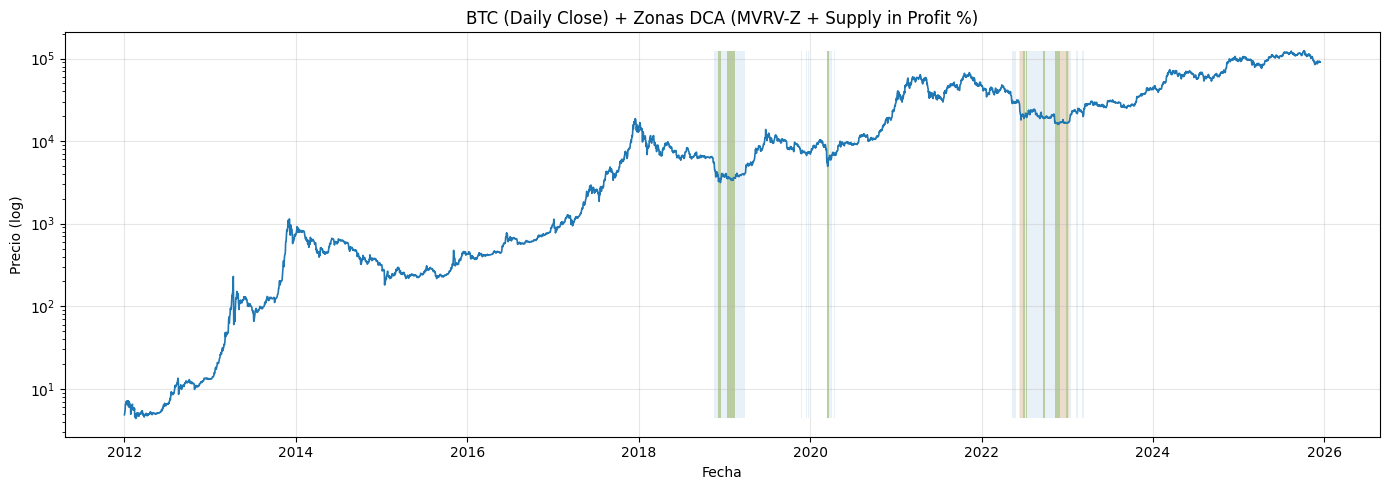


ZONAS DCA: OK
Plot : c:\Quant\BTC_ANALIST\data\processed\btc_dca_zones_plot.png
Tabla: c:\Quant\BTC_ANALIST\data\processed\btc_dca_zones_table.csv

Últimas zonas detectadas (si existen):
 zone_id      start        end  days  min_low  min_close  min_mvrvz   min_sip  max_level  fwd_180d_pct  fwd_365d_pct
      26 2020-04-19 2020-04-22     4  6757.75    6768.81   0.396770 57.969620          1     58.433501    684.094723
      28 2022-05-09 2022-05-14     6 25401.05   28558.82   0.331985 55.949463          1    -31.085496    -10.451522
      30 2022-05-16 2022-05-29    14 28003.00   28855.34   0.339730 54.289479          1    -43.043047     -8.913516
      32 2022-06-01 2022-06-01     1 29869.97   30104.83   0.424345 58.259441          1    -46.334193    -10.755184
      34 2022-06-03 2022-06-05     3 29232.99   29562.14   0.418115 57.979444          1    -42.744334     -8.298249
      36 2022-06-08 2023-01-19   226 15479.00   15954.00  -0.359866 46.839554          3    -43.392217    -11.

In [12]:
# ============================================================
# CELDA: ZONAS DCA (CUANT) -> MVRV-Z + Supply in Profit % (+ opcional Profit Addresses %)
# - Grafica zonas sombreadas tipo TradingView
# - Exporta tabla de zonas a ./data/processed/
# Requiere:
# - Precio 4H parquet:  data/processed/btc_4h_full.parquet  (o ruta equivalente)
# - On-chain daily CSV: data/processed/btc_onchain_daily_bgeometrics_complete.csv
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0) Resolver rutas (robusto)
# ---------------------------
cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, "..")) if os.path.basename(cwd).lower() == "notebooks" else cwd

PARQUET_CANDIDATES = [
    os.path.join(project_root, "data", "processed", "btc_4h_full.parquet"),
    os.path.join(project_root, "data_engine", "btc_4h_full.parquet"),
    os.path.join(project_root, "data_engine", "btc_4h_full.parquet"),
]
parquet_path = next((p for p in PARQUET_CANDIDATES if os.path.exists(p)), None)
if parquet_path is None:
    raise FileNotFoundError(
        "No encuentro btc_4h_full.parquet. Probé:\n- " + "\n- ".join(PARQUET_CANDIDATES)
    )

ONCHAIN_COMPLETE = os.path.join(project_root, "data", "processed", "btc_onchain_daily_bgeometrics_complete.csv")
ONCHAIN_FULL     = os.path.join(project_root, "data", "processed", "btc_onchain_daily_bgeometrics.csv")
onchain_path = ONCHAIN_COMPLETE if os.path.exists(ONCHAIN_COMPLETE) else ONCHAIN_FULL
if not os.path.exists(onchain_path):
    raise FileNotFoundError(
        "No encuentro on-chain CSV. Esperaba:\n"
        f"- {ONCHAIN_COMPLETE}\n- {ONCHAIN_FULL}"
    )

out_dir = os.path.join(project_root, "data", "processed")
os.makedirs(out_dir, exist_ok=True)

print("PROJECT_ROOT:", project_root)
print("PRICE_PARQUET:", parquet_path)
print("ONCHAIN_CSV :", onchain_path)
print("OUT_DIR     :", out_dir)

# ---------------------------
# 1) Precio diario desde 4H
# ---------------------------
df_4h = pd.read_parquet(parquet_path)
df_4h.columns = [c.lower().strip() for c in df_4h.columns]
df_4h["time"] = pd.to_datetime(df_4h["time"], errors="coerce", utc=True)
df_4h = df_4h.dropna(subset=["time", "open", "high", "low", "close"]).sort_values("time")

df_px = (
    df_4h.set_index("time")[["open","high","low","close"]]
    .resample("1D")
    .agg({"open":"first", "high":"max", "low":"min", "close":"last"})
    .dropna()
    .reset_index()
)
df_px["date"] = df_px["time"].dt.date

# ---------------------------
# 2) On-chain diario (BGeometrics + supply)
# ---------------------------
df_on = pd.read_csv(onchain_path)
df_on.columns = [c.lower().strip() for c in df_on.columns]
if "date" not in df_on.columns:
    raise ValueError("El on-chain CSV debe tener columna 'date'.")

df_on["date"] = pd.to_datetime(df_on["date"], errors="coerce").dt.date
df_on = df_on.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# Merge
df = df_px.merge(df_on, on="date", how="left").sort_values("date").reset_index(drop=True)

# ---------------------------
# 3) Features + Zonas DCA (cuantitativas)
# Idea: usar percentiles rolling (sin lookahead) para adaptarse a proveedor/escala.
# ---------------------------
LOOKBACK_DAYS = 1460  # ~4 años. Ajustable.
MINP = 365

def rolling_q(s, q):
    return s.rolling(LOOKBACK_DAYS, min_periods=MINP).quantile(q)

# Señales base disponibles
has_mvrvz = "mvrv_z_score" in df.columns and df["mvrv_z_score"].notna().any()
has_sip   = "supply_in_profit_pct" in df.columns and df["supply_in_profit_pct"].notna().any()

if not has_mvrvz:
    raise ValueError("No hay mvrv_z_score disponible. Es la columna clave para el régimen de valoración.")

# Percentiles rolling para niveles (adaptativos)
# Para undervaluation queremos valores BAJOS:
df["mvrvz_q20"] = rolling_q(df["mvrv_z_score"], 0.20)
df["mvrvz_q10"] = rolling_q(df["mvrv_z_score"], 0.10)

if has_sip:
    df["sip_q35"] = rolling_q(df["supply_in_profit_pct"], 0.35)
    df["sip_q20"] = rolling_q(df["supply_in_profit_pct"], 0.20)
    df["sip_q10"] = rolling_q(df["supply_in_profit_pct"], 0.10)

# Opcional: si existe Profit Addresses % real (IntoTheBlock u otro)
# Debe venir como % (0-100). Si lo tienes 0-1, conviértelo antes.
has_paddr = "profit_addresses_pct" in df.columns and df["profit_addresses_pct"].notna().any()
if has_paddr:
    df["paddr_q35"] = rolling_q(df["profit_addresses_pct"], 0.35)
    df["paddr_q20"] = rolling_q(df["profit_addresses_pct"], 0.20)
    df["paddr_q10"] = rolling_q(df["profit_addresses_pct"], 0.10)

# Construcción de niveles de zona DCA:
# lvl=1 (Value):   MVRVZ bajo (<= q20) y (si hay SIP) SIP bajo moderado (<= q35)
# lvl=2 (Deep):    MVRVZ <= q10 y SIP <= q20
# lvl=3 (Extreme): MVRVZ <= q10 y SIP <= q10   (capitulación fuerte)
df["dca_level"] = 0

# Nivel 1 (siempre que haya percentiles disponibles)
cond1 = df["mvrv_z_score"].notna() & df["mvrvz_q20"].notna() & (df["mvrv_z_score"] <= df["mvrvz_q20"])
if has_sip:
    cond1 = cond1 & df["sip_q35"].notna() & (df["supply_in_profit_pct"] <= df["sip_q35"])
df.loc[cond1, "dca_level"] = 1

# Nivel 2
cond2 = df["mvrv_z_score"].notna() & df["mvrvz_q10"].notna() & (df["mvrv_z_score"] <= df["mvrvz_q10"])
if has_sip:
    cond2 = cond2 & df["sip_q20"].notna() & (df["supply_in_profit_pct"] <= df["sip_q20"])
df.loc[cond2, "dca_level"] = 2

# Nivel 3
cond3 = df["mvrv_z_score"].notna() & df["mvrvz_q10"].notna() & (df["mvrv_z_score"] <= df["mvrvz_q10"])
if has_sip:
    cond3 = cond3 & df["sip_q10"].notna() & (df["supply_in_profit_pct"] <= df["sip_q10"])
df.loc[cond3, "dca_level"] = 3

# Si tienes Profit Addresses %, lo usamos como “confirmación” (solo para elevar nivel)
if has_paddr:
    up2 = df["paddr_q20"].notna() & (df["profit_addresses_pct"] <= df["paddr_q20"]) & (df["dca_level"] < 2)
    up3 = df["paddr_q10"].notna() & (df["profit_addresses_pct"] <= df["paddr_q10"]) & (df["dca_level"] < 3)
    df.loc[up2, "dca_level"] = 2
    df.loc[up3, "dca_level"] = 3

df["dca_on"] = df["dca_level"] > 0

# ---------------------------
# 4) Tabla de zonas (intervalos)
# ---------------------------
df["zone_id"] = (df["dca_on"] != df["dca_on"].shift(1)).cumsum()
zones = (
    df[df["dca_on"]]
    .groupby("zone_id", as_index=False)
    .agg(
        start=("date","min"),
        end=("date","max"),
        days=("date","count"),
        min_low=("low","min"),
        min_close=("close","min"),
        min_mvrvz=("mvrv_z_score","min"),
        min_sip=("supply_in_profit_pct","min") if has_sip else ("mvrv_z_score","min"),
        max_level=("dca_level","max"),
    )
)

# Forward returns (solo diagnóstico; no es recomendación)
didx = pd.to_datetime(df["date"])
close = pd.Series(df["close"].values, index=didx)

def fwd_ret_pct(h):
    fut = close.shift(-h)
    return (fut / close - 1.0) * 100.0

df["fwd_180d_pct"] = fwd_ret_pct(180).values
df["fwd_365d_pct"] = fwd_ret_pct(365).values

zone_starts = df[df["dca_on"]].groupby("zone_id").first().reset_index()[["zone_id","fwd_180d_pct","fwd_365d_pct"]]
zones = zones.merge(zone_starts, on="zone_id", how="left").sort_values("start").reset_index(drop=True)

zones_csv = os.path.join(out_dir, "btc_dca_zones_table.csv")
zones.to_csv(zones_csv, index=False, encoding="utf-8")

# ---------------------------
# 5) Plot (shading tipo TradingView)
# ---------------------------
dates = pd.to_datetime(df["date"])

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(dates, df["close"], linewidth=1.2)
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

ymin, ymax = df["close"].min(), df["close"].max()

# sombreado por nivel (mientras mayor nivel, mayor alpha)
for lvl, alpha in [(1, 0.10), (2, 0.18), (3, 0.26)]:
    mask = (df["dca_level"] >= lvl).fillna(False).values
    ax.fill_between(dates, ymin, ymax, where=mask, alpha=alpha, step="pre")

title = "BTC (Daily Close) + Zonas DCA (MVRV-Z + Supply in Profit %)"
if has_paddr:
    title += " + Profit Addresses %"
ax.set_title(title)
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio (log)")

plot_path = os.path.join(out_dir, "btc_dca_zones_plot.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()

print("\n==========================================")
print("ZONAS DCA: OK")
print("==========================================")
print("Plot :", plot_path)
print("Tabla:", zones_csv)
print("\nÚltimas zonas detectadas (si existen):")
print(zones.tail(10).to_string(index=False))


In [13]:
# ============================================================
# CELDA: QA / AUDITORÍA DE DATOS ON-CHAIN (continuidad + rangos + consistencia)
# - Detecta huecos en el medio (missing intervals)
# - Diagnostica parsing/unidades
# - Verifica identidad: supply_in_profit_pct ~ supply_in_profit_btc / btc_supply_total
# ============================================================

import os
import numpy as np
import pandas as pd

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, "..")) if os.path.basename(cwd).lower() == "notebooks" else cwd
processed = os.path.join(project_root, "data", "processed")

csv_complete = os.path.join(processed, "btc_onchain_daily_bgeometrics_complete.csv")
csv_full     = os.path.join(processed, "btc_onchain_daily_bgeometrics.csv")

path = csv_complete if os.path.exists(csv_complete) else csv_full
if not os.path.exists(path):
    raise FileNotFoundError(f"No encuentro:\n- {csv_complete}\n- {csv_full}")

df = pd.read_csv(path)
df.columns = [c.lower().strip() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Limpieza base
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
df["date_d"] = df["date"].dt.date

print("==========================================")
print("QA ON-CHAIN: archivo cargado")
print("==========================================")
print("PATH:", path)
print("FILAS:", len(df))
print("RANGO:", df["date_d"].min(), "->", df["date_d"].max())
print("COLUMNAS:", list(df.columns))
print()

# ---------------------------
# 1) Calendario diario esperado
# ---------------------------
full_range = pd.date_range(df["date"].min().normalize(), df["date"].max().normalize(), freq="D")
calendar = pd.DataFrame({"date": full_range})
calendar["date_d"] = calendar["date"].dt.date

# ---------------------------
# 2) Función para encontrar intervalos faltantes
# ---------------------------
def missing_intervals(series_dates: pd.Series):
    """
    series_dates: Serie de datetime normalizada o date.
    Retorna lista de intervalos faltantes (start, end, n_days).
    """
    s = pd.to_datetime(series_dates, errors="coerce").dropna().dt.normalize()
    if s.empty:
        return []

    rng = pd.date_range(s.min(), s.max(), freq="D")
    present = pd.Index(s.unique())
    missing = rng.difference(present)
    if len(missing) == 0:
        return []

    # Agrupar días consecutivos
    miss = pd.Series(missing).sort_values().reset_index(drop=True)
    breaks = miss.diff().dt.days.fillna(1).ne(1).cumsum()
    out = []
    for _, g in miss.groupby(breaks):
        out.append((g.iloc[0].date(), g.iloc[-1].date(), len(g)))
    return out

# ---------------------------
# 3) Continuidad por columna (huecos "en medio")
# ---------------------------
cols_to_check = [c for c in df.columns if c not in ("date", "date_d")]

report = []
for col in cols_to_check:
    # Fechas donde hay dato (no NaN)
    mask = df[col].notna()
    s_dates = df.loc[mask, "date"]
    if s_dates.empty:
        report.append({"col": col, "coverage_days": 0, "missing_intervals": "ALL_MISSING"})
        continue

    intervals = missing_intervals(s_dates)
    report.append({
        "col": col,
        "coverage_days": int(mask.sum()),
        "start": df.loc[mask, "date_d"].min(),
        "end": df.loc[mask, "date_d"].max(),
        "n_missing_intervals": len(intervals),
        "missing_intervals_sample": intervals[:5]  # muestra primeros 5
    })

qa = pd.DataFrame(report).sort_values(["n_missing_intervals","coverage_days"], ascending=[False, True])

print("==========================================")
print("QA: Continuidad / huecos por columna")
print("==========================================")
print(qa.to_string(index=False))
print()

# ---------------------------
# 4) Checks de rango/unidades (sanity)
# ---------------------------
def sanity_range(name, s, lo, hi):
    s = pd.to_numeric(s, errors="coerce")
    ok = s.dropna().between(lo, hi).mean() if s.notna().any() else np.nan
    return {"metric": name, "in_range_ratio": ok, "min": s.min(), "median": s.median(), "max": s.max()}

checks = []
if "mvrv" in df.columns:
    checks.append(sanity_range("mvrv", df["mvrv"], 0.0, 50.0))
if "mvrv_z_score" in df.columns:
    checks.append(sanity_range("mvrv_z_score", df["mvrv_z_score"], -10.0, 100.0))
if "supply_in_profit_btc" in df.columns:
    checks.append(sanity_range("supply_in_profit_btc", df["supply_in_profit_btc"], 0.0, 2.1e7))
if "btc_supply_total" in df.columns:
    checks.append(sanity_range("btc_supply_total", df["btc_supply_total"], 0.0, 2.1e7))
if "supply_in_profit_pct" in df.columns:
    checks.append(sanity_range("supply_in_profit_pct", df["supply_in_profit_pct"], 0.0, 100.0))
if "utxos_in_profit_pct" in df.columns:
    checks.append(sanity_range("utxos_in_profit_pct", df["utxos_in_profit_pct"], 0.0, 100.0))

san = pd.DataFrame(checks)
print("==========================================")
print("QA: Sanity de rangos (unidades)")
print("==========================================")
print(san.to_string(index=False))
print()

# ---------------------------
# 5) Consistencia interna: % = btc_in_profit / supply_total * 100
# ---------------------------
if all(c in df.columns for c in ["supply_in_profit_btc", "btc_supply_total", "supply_in_profit_pct"]):
    x = pd.to_numeric(df["supply_in_profit_btc"], errors="coerce")
    y = pd.to_numeric(df["btc_supply_total"], errors="coerce")
    pct = pd.to_numeric(df["supply_in_profit_pct"], errors="coerce")

    implied = (x / y) * 100.0
    diff = (pct - implied).abs()

    # Solo donde todo existe
    ok_mask = x.notna() & y.notna() & pct.notna() & implied.notna() & (y > 0)

    if ok_mask.any():
        mae = diff[ok_mask].mean()
        p95 = diff[ok_mask].quantile(0.95)
        print("==========================================")
        print("QA: Consistencia interna supply_in_profit_pct")
        print("==========================================")
        print(f"MAE abs(pct - implied): {mae:.6f} puntos porcentuales")
        print(f"P95 abs diff         : {p95:.6f}")
        print("Interpretación: si MAE ~ 0 y P95 pequeño, no hubo error de parsing/units.")
        print()
    else:
        print("QA: No hay suficientes filas con (btc_in_profit, supply_total, pct) simultáneos para validar.")
        print()

# ---------------------------
# 6) Exportar QA
# ---------------------------
out_qa = os.path.join(processed, "qa_onchain_report.csv")
qa.to_csv(out_qa, index=False, encoding="utf-8")
print("QA guardado en:", out_qa)


QA ON-CHAIN: archivo cargado
PATH: c:\Quant\BTC_ANALIST\data\processed\btc_onchain_daily_bgeometrics_complete.csv
FILAS: 6236
RANGO: 2009-01-03 -> 2026-01-29
COLUMNAS: ['date', 'mvrv', 'mvrv_z_score', 'supply_in_profit_btc', 'btc_supply_total', 'utxos_in_profit_pct', 'supply_in_profit_pct', 'profit_avg_pct_proxy', 'date_d']

QA: Continuidad / huecos por columna
                 col  coverage_days      start        end  n_missing_intervals                                                                                                                          missing_intervals_sample
 utxos_in_profit_pct           1089 2022-12-07 2025-12-06                    6 [(2024-02-15, 2024-02-15, 1), (2024-05-16, 2024-05-16, 1), (2024-06-06, 2024-06-06, 1), (2024-06-14, 2024-06-14, 1), (2024-09-03, 2024-09-04, 2)]
supply_in_profit_btc           3676 2016-01-01 2026-01-29                    6 [(2023-11-24, 2023-11-24, 1), (2023-11-27, 2023-11-27, 1), (2023-11-29, 2023-11-29, 1), (2023-12-02, 2023-1

In [14]:
# ============================================================
# CELDA: BitcoinIsData – Explorar métricas + descarga ejemplo
# ============================================================

import os, sys, time, re, subprocess
import pandas as pd
import numpy as np
from io import StringIO

def _ensure(pkg_import: str, pip_name: str = None):
    try:
        return __import__(pkg_import)
    except Exception:
        pip_name = pip_name or pkg_import
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        return __import__(pkg_import)

requests = _ensure("requests")
bs4 = _ensure("bs4", "beautifulsoup4")
from bs4 import BeautifulSoup

API_KEY = "UfYJHdDb-BmGn2Ljz0YeNA"
API_URL = "https://bitcoinisdata.com/api/get_data"
DATA_PAGE_URL = "https://bitcoinisdata.com/data/"
START_BLOCK = 875000
END_BLOCK   = 875010

def extract_fields_from_data_page(html: str):
    soup = BeautifulSoup(html, "html.parser")
    fields = {code.get_text().strip() for code in soup.find_all("code")}
    return sorted({f for f in fields if f and " " not in f and len(f) < 100})

def _json_to_df(js):
    if isinstance(js, list): return pd.DataFrame(js)
    if isinstance(js, dict):
        for key in ["data", "rows", "result", "items"]:
            if key in js and isinstance(js[key], list):
                return pd.DataFrame(js[key])
        if all(isinstance(v, list) for v in js.values()):
            return pd.DataFrame(js)
        if "error" in js or "message" in js: raise RuntimeError(f"Error: {js}")
        return pd.DataFrame([js])
    if isinstance(js, str) and "\n" in js and "," in js:
        return pd.read_csv(StringIO(js))
    raise RuntimeError("Respuesta JSON no tabular o inválida.")

def fetch_sample(start_block, end_block, columns=None, fmt="json", timeout=60):
    params = {
        "api_key": API_KEY,
        "start_block": start_block,
        "end_block": end_block,
        "format": fmt,
    }
    if columns:
        params["columns"] = ",".join(columns) if isinstance(columns, list) else str(columns)
    r = requests.get(API_URL, params=params, timeout=timeout)
    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code}: {r.text[:300]}")
    try:
        return _json_to_df(r.json())
    except Exception:
        return pd.read_csv(StringIO(r.text.strip()))

print("==========================================")
print("BitcoinIsData: Verificando acceso API")
print("==========================================")
try:
    df_test = fetch_sample(START_BLOCK, END_BLOCK)
    print("✅ Acceso OK. Filas:", len(df_test), "| Columnas:", df_test.columns[:10].tolist())
except Exception as e:
    raise RuntimeError(f"❌ Error al conectar: {e}")

print("\n==========================================")
print("Descubriendo columnas disponibles desde /data/")
print("==========================================")
try:
    r_html = requests.get(DATA_PAGE_URL, timeout=60)
    all_fields = extract_fields_from_data_page(r_html.text)
    print("🔎 Total métricas detectadas:", len(all_fields))
    print("Ejemplos:", all_fields[:10])
except Exception as e:
    print("❌ No se pudo acceder a /data/:", e)
    all_fields = []

# Buscar campos clave para DCA/DSA
def pick(*candidates): return next((c for c in candidates if c in all_fields), None)

wanted_cols = list(filter(None, [
    pick("date", "datetime"),
    pick("mvrv"),
    pick("mvrv_z_score", "mvrv-z-score"),
    pick("coins_in_profit_pct"),
    pick("avg_profit_percentage"),
    pick("STH_mvrv<3m", "STH_mvrv<6m"),
    pick("LTH_mvrv>1y"),
    pick("NUPL", "total_nupl"),
    pick("hodl_waves_>4y", "percentage_hodl_waves_>4y"),
]))

print("\n==========================================")
print("Descargando muestra orientada de métricas clave")
print("==========================================")
print("Campos solicitados:", wanted_cols)

df_sig = fetch_sample(START_BLOCK, START_BLOCK + 50, columns=wanted_cols)
print("✅ Datos descargados | Filas:", len(df_sig))
print("Columnas:", df_sig.columns.tolist())
print(df_sig.tail(3).to_string(index=False))


BitcoinIsData: Verificando acceso API
✅ Acceso OK. Filas: 0 | Columnas: ['Hello hectorldu, subscription EXPIRED.']

Descubriendo columnas disponibles desde /data/
🔎 Total métricas detectadas: 1
Ejemplos: ['qtd_new_addr_total']

Descargando muestra orientada de métricas clave
Campos solicitados: []
✅ Datos descargados | Filas: 0
Columnas: ['Hello hectorldu, subscription EXPIRED.']
Empty DataFrame
Columns: [Hello hectorldu, subscription EXPIRED.]
Index: []


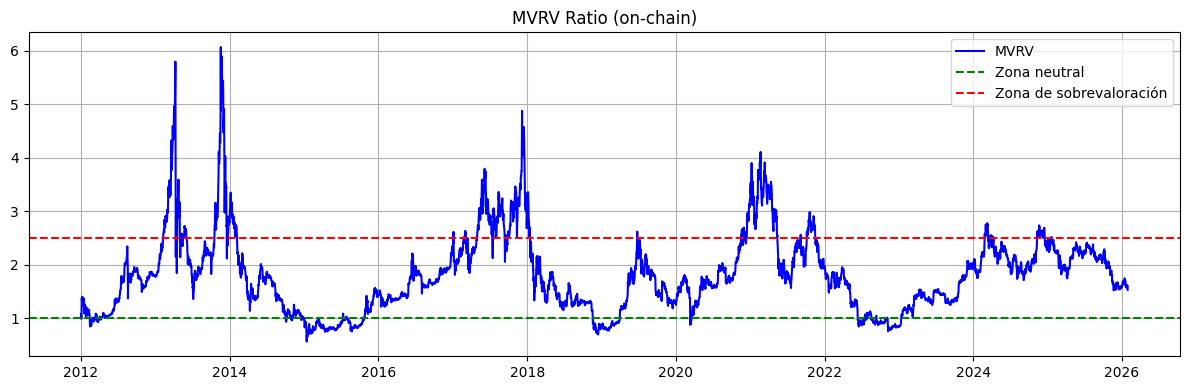

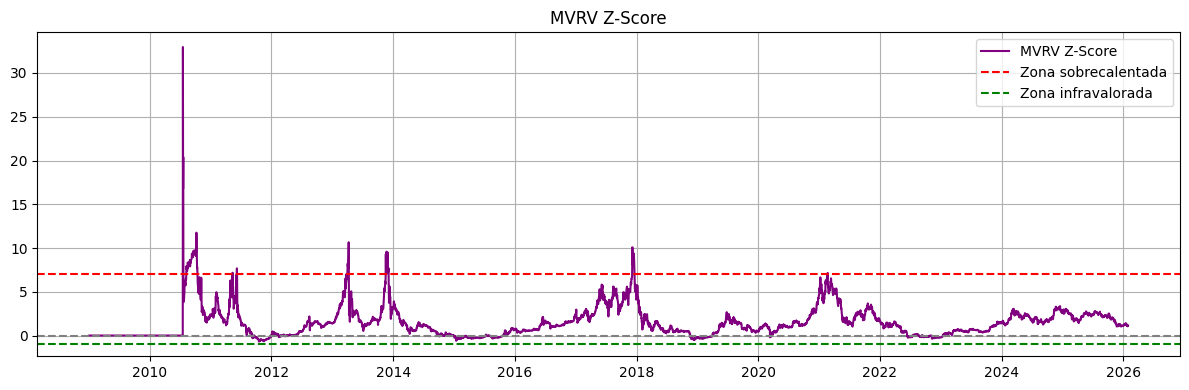

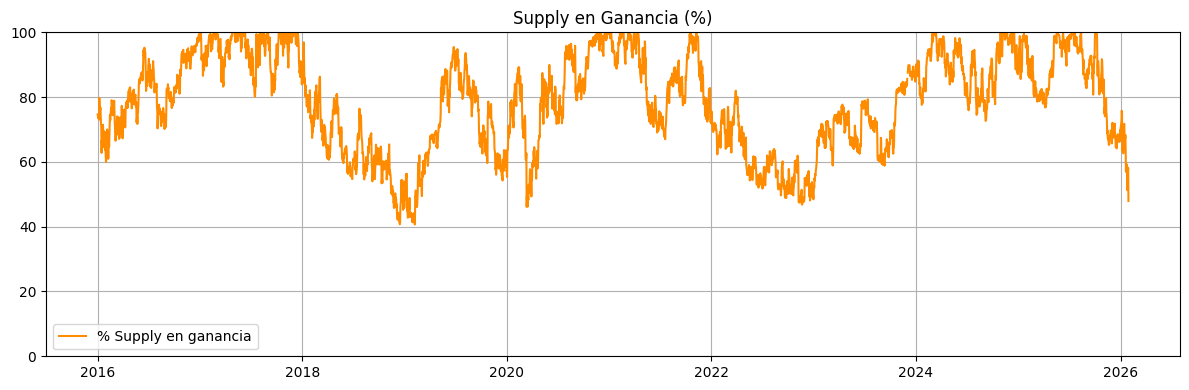

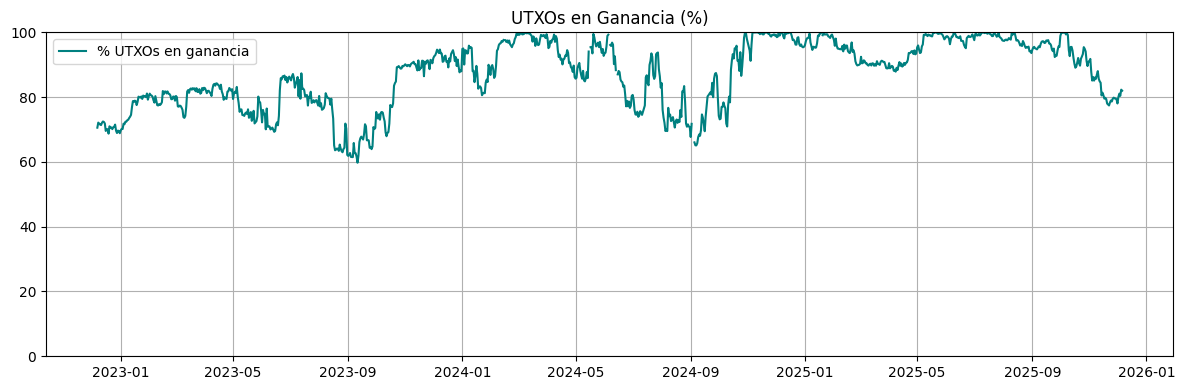

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de tener el DataFrame df cargado y con columnas: 'date', 'mvrv', 'mvrv_z_score', 'supply_in_profit_pct', 'utxos_in_profit_pct'

# Convertir columna fecha y ordenar
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date')

# Gráfico 1: MVRV
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['mvrv'], label='MVRV', color='blue')
plt.axhline(1.0, color='green', linestyle='--', label='Zona neutral')
plt.axhline(2.5, color='red', linestyle='--', label='Zona de sobrevaloración')
plt.title('MVRV Ratio (on-chain)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: MVRV Z-Score
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['mvrv_z_score'], label='MVRV Z-Score', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(7, color='red', linestyle='--', label='Zona sobrecalentada')
plt.axhline(-1, color='green', linestyle='--', label='Zona infravalorada')
plt.title('MVRV Z-Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 3: % de Supply en ganancia
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['supply_in_profit_pct'], label='% Supply en ganancia', color='darkorange')
plt.title('Supply en Ganancia (%)')
plt.grid(True)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 4: % UTXOs en ganancia (si existe)
if 'utxos_in_profit_pct' in df.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df['utxos_in_profit_pct'], label='% UTXOs en ganancia', color='teal')
    plt.title('UTXOs en Ganancia (%)')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()
 

In [16]:
# ============================================================
# CELDA 13B v2.6: BitcoinIsData – QA MASIVO DE RATIOS (QA)
# (FIX: detecta core cols vía API + unidades BTC/sats + % por grupos)
# ============================================================

import os, re, math, time
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

API_URL = "https://bitcoinisdata.com/api/get_data"
DATA_PAGE_URL = "https://bitcoinisdata.com/data/"

API_KEY = "UfYJHdDb-BmGn2Ljz0YeNA"

START_BLOCK = 875000
END_BLOCK   = 875010

# -------------------------
# Helpers: parse /data/
# -------------------------
def extract_fields_from_data_page(html: str):
    soup = BeautifulSoup(html, "html.parser")
    code_blocks = [c.get_text().strip() for c in soup.find_all("code")]

    fields = []
    for block in code_blocks:
        parts = [p.strip() for p in block.split(",")]
        for p in parts:
            if not p:
                continue
            if p in {"...", "…"} or "..." in p:
                continue
            if re.search(r"\s", p):
                continue
            fields.append(p)

    return sorted(set(fields))

# -------------------------
# API fetch
# -------------------------
def _json_to_df(js):
    if isinstance(js, list):
        return pd.DataFrame(js)
    if isinstance(js, dict):
        for key in ["data", "rows", "result", "items"]:
            if key in js and isinstance(js[key], list):
                return pd.DataFrame(js[key])
        if "error" in js or "message" in js:
            raise RuntimeError(f"API error payload: {js}")
        return pd.DataFrame([js])
    raise RuntimeError("Respuesta JSON no tabular.")

def fetch_sample(start_block, end_block, columns=None, fmt="json", timeout=180, max_retries=3):
    if not API_KEY:
        raise RuntimeError("❌ API_KEY vacío.")

    params = {"api_key": API_KEY, "start_block": int(start_block), "end_block": int(end_block), "format": fmt}
    if columns:
        params["columns"] = ",".join(columns) if isinstance(columns, (list, tuple)) else str(columns)

    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(API_URL, params=params, timeout=timeout)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP {r.status_code}: {r.text[:300]}")
            try:
                return _json_to_df(r.json())
            except Exception:
                from io import StringIO
                return pd.read_csv(StringIO(r.text))
        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(1.0 * attempt)
            else:
                raise last_err

# -------------------------
# QC / utilidades
# -------------------------
def coerce_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def infer_bounds(col: str):
    c = col.lower()

    if c in {"avg_profit_percentage", "avg_loss_percentage"}:
        return ("avg_return_pct", -1e12, 1e12)

    if ("roi" in c) or ("cagr" in c) or ("yoy" in c):
        return ("return", -1e12, 1e12)

    if ("pct" in c) or ("percent" in c) or (c.startswith("percentage_")):
        return ("pct_bounded", -0.5, 100.5)

    if "nupl" in c:
        return ("nupl", -1.5, 1.5)

    if ("z_score" in c) or ("z-score" in c) or ("zscore" in c):
        return ("zscore", -50.0, 50.0)

    if "sopr" in c or "mvrv" in c or "puell" in c or "mayer" in c:
        return ("ratio", 0.0, 50.0)

    if "nvt" in c:
        return ("nvt", 0.0, 50000.0)

    if "ratio" in c or "multiple" in c or "multiplier" in c:
        return ("ratio", 0.0, 1e18)

    return ("other", -np.inf, np.inf)

def qc_table(df_num: pd.DataFrame, metrics: list, title: str, topn=30):
    rows = []
    for col in metrics:
        if col not in df_num.columns:
            continue
        s = df_num[col]
        total = len(df_num)
        non_null = int(s.notna().sum())
        non_null_pct = (non_null / total * 100.0) if total else 0.0

        kind, lo, hi = infer_bounds(col)
        oor_pct = 0.0
        if non_null and (math.isfinite(lo) or math.isfinite(hi)):
            oor = ((s < lo) | (s > hi)) & s.notna()
            oor_pct = float(oor.sum()) / non_null * 100.0

        scale_hint = None
        if kind == "pct_bounded" and non_null:
            vmax = float(s.max())
            scale_hint = "0–100 probable" if vmax > 1.5 else "pequeño: puede ser <1% (0–100) o fracción (0–1)"

        rows.append({
            "metric": col,
            "kind": kind,
            "scale_hint": scale_hint,
            "non_null_%": round(non_null_pct, 2),
            "min": float(s.min()) if non_null else np.nan,
            "median": float(s.median()) if non_null else np.nan,
            "max": float(s.max()) if non_null else np.nan,
            "out_of_range_%": round(oor_pct, 2),
        })

    qc = pd.DataFrame(rows)
    qc_sorted = qc.sort_values(by=["out_of_range_%", "non_null_%"], ascending=[False, True]).reset_index(drop=True)

    print("\n==========================================")
    print(title)
    print("==========================================")
    display(qc_sorted.head(topn))
    return qc_sorted

# -------------------------
# UNIDADES (BTC vs satoshis)
# -------------------------
SATOSHIS_PER_BTC = 1e8

def _median_pos(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce")
    x = x[np.isfinite(x)]
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return float(np.median(x))

def infer_coin_unit(series: pd.Series):
    med = _median_pos(series)
    if not np.isfinite(med):
        return ("unknown", 1.0, med)

    if med >= 1e12:
        return ("sats", 1.0 / SATOSHIS_PER_BTC, med)
    if 1e6 <= med <= 1e9:
        return ("btc", 1.0, med)

    if abs(math.log10(med) - 15) < abs(math.log10(med) - 7):
        return ("sats?", 1.0 / SATOSHIS_PER_BTC, med)
    return ("btc?", 1.0, med)

def choose_profit_loss_pct_scaling(df_num_norm: pd.DataFrame):
    a, b = "coins_in_profit_pct", "coins_in_loss_pct"
    if not ({a, b}.issubset(df_num_norm.columns)):
        return (None, None)

    profit = df_num_norm[a].copy()
    loss   = df_num_norm[b].copy()

    s1 = profit + loss
    err1 = (s1 - 100.0).abs().median()

    s2 = profit + (loss * 100.0)
    err2 = (s2 - 100.0).abs().median()

    if np.isfinite(err2) and (err2 + 1e-9) < err1:
        return (True, {"check": "profit_pct + loss_pct ≈ 100", "decision": "loss x100 (parece 0–1)", "median_abs_err_noop": float(err1), "median_abs_err_x100": float(err2)})
    else:
        return (False, {"check": "profit_pct + loss_pct ≈ 100", "decision": "no-op (loss parece % pequeño en 0–100)", "median_abs_err_noop": float(err1), "median_abs_err_x100": float(err2)})

# ============================================================
# EJECUCIÓN
# ============================================================

print("==========================================")
print("BitcoinIsData – QA MASIVO DE RATIOS (v2.6)")
print("==========================================")
print(f"Rango de bloques: {START_BLOCK} → {END_BLOCK}")

# 1) Leer /data/ y extraer campos
r_html = requests.get(DATA_PAGE_URL, timeout=60)
print(f"/data/ HTTP: {r_html.status_code} | bytes: {len(r_html.text)}")
if r_html.status_code != 200:
    raise RuntimeError(f"❌ No pude leer {DATA_PAGE_URL}: HTTP {r_html.status_code}")

all_fields = extract_fields_from_data_page(r_html.text)
print(f"✅ Campos detectados (parseados): {len(all_fields)}")
print("Ejemplo campos:", all_fields[:25])

# 2) Ratios + IDs
ratio_pattern = re.compile(
    r"(ratio|pct|percent|percentage|mvrv|nupl|sopr|puell|z[_\-]?score|nvt|mayer|multiple|multiplier|roi|cagr|yoy)",
    re.IGNORECASE
)
ratio_cols = [c for c in all_fields if ratio_pattern.search(c)]

id_candidates = ["heights", "datetime", "date"]
id_cols = [c for c in id_candidates if c in all_fields]
print(f"Ratios detectados: {len(ratio_cols)}")
print("Ejemplos ratios:", ratio_cols[:25])
print("ID cols detectados:", id_cols if id_cols else "Ninguno")

if not id_cols and "heights" in all_fields:
    id_cols = ["heights"]

if len(ratio_cols) == 0:
    raise RuntimeError("❌ No se detectaron ratios (regex demasiado estricta o /data/ cambió).")

# 3) Core cols (detectarlas vía API para que identidades SIEMPRE tengan chance)
core_candidates = [
    "price","coins","market_cap",
    "coins_in_profit","coins_in_loss",
    "coins_in_profit_pct","coins_in_loss_pct",
    "avg_profit_percentage","avg_loss_percentage"
]

print("\n--- Smoke test API (core detect) ---")
df_core_probe = fetch_sample(START_BLOCK, END_BLOCK, columns=list(dict.fromkeys(id_cols + core_candidates)), fmt="json", timeout=180)
core_cols = [c for c in core_candidates if c in df_core_probe.columns]
print("✅ Core cols disponibles (API):", core_cols)

# Smoke básico
smoke_cols = [c for c in (id_cols + ["date", "price"]) if c in (all_fields + core_cols)]
smoke_cols = list(dict.fromkeys(smoke_cols))[:4]
df_smoke = fetch_sample(START_BLOCK, END_BLOCK, columns=smoke_cols, fmt="json", timeout=180)
print("✅ API OK | filas:", len(df_smoke), "| cols:", list(df_smoke.columns))

# 4) Descarga por chunks
CHUNK_SIZE = 30
ratio_chunks = [ratio_cols[i:i+CHUNK_SIZE] for i in range(0, len(ratio_cols), CHUNK_SIZE)]

dfs = []
bad_cols = []

for k, chunk in enumerate(ratio_chunks, 1):
    cols_req = list(dict.fromkeys(id_cols + core_cols + chunk))
    try:
        df_part = fetch_sample(START_BLOCK, END_BLOCK, columns=cols_req, fmt="json", timeout=180)
        dfs.append(df_part)
        print(f"  ✅ chunk {k}/{len(ratio_chunks)} OK | cols: {len(cols_req)} | filas: {len(df_part)}")
    except Exception as e:
        print(f"  ⚠️ chunk {k}/{len(ratio_chunks)} FALLÓ → fallback por columna | error: {e}")
        for col in chunk:
            cols_req_1 = list(dict.fromkeys(id_cols + core_cols + [col]))
            try:
                df_1 = fetch_sample(START_BLOCK, END_BLOCK, columns=cols_req_1, fmt="json", timeout=180)
                dfs.append(df_1)
            except Exception:
                bad_cols.append(col)

if not dfs:
    raise RuntimeError("❌ No se pudo descargar nada (API caída, key inválida, o bloqueo del servidor).")

# 5) Merge por keys
preferred_keys = [k for k in ["heights","datetime","date"] if k in id_cols] or id_cols[:1]
merge_keys = preferred_keys

df = dfs[0].copy()
for d in dfs[1:]:
    keys_here = [k for k in merge_keys if (k in df.columns and k in d.columns)]
    if keys_here:
        df = pd.merge(df, d, on=keys_here, how="outer")
    else:
        df = pd.concat([df, d], axis=1)

df = df.loc[:, ~df.columns.duplicated()].copy()

print("\n==========================================")
print("Dataset consolidado")
print("==========================================")
print("Filas:", len(df), "| Columnas:", len(df.columns))
if bad_cols:
    print(f"⚠️ Columnas que fallaron incluso individual: {len(bad_cols)} (primeras 30): {bad_cols[:30]}")

# 6) Coerción numérica
df_num = df.copy()
for c in df_num.columns:
    if c in merge_keys:
        continue
    df_num[c] = coerce_numeric(df_num[c])

ratio_cols_present = [c for c in ratio_cols if c in df_num.columns]

# 7) QC PRE
qc_pre = qc_table(df_num, ratio_cols_present, "TOP 30 (QC) PRE-normalización", topn=30)

# 8) Normalización por grupos percentage_* con sum≈1
df_num_norm = df_num.copy()
normalized_cols = []

def normalize_group(prefix: str):
    cols = [c for c in df_num_norm.columns if c.startswith(prefix)]
    if len(cols) < 2:
        return None

    grp = df_num_norm[cols].copy()
    ssum = grp.sum(axis=1, skipna=True)
    med = float(ssum.median()) if len(ssum) else np.nan

    if np.isfinite(med) and (0.85 <= med <= 1.15):
        for c in cols:
            df_num_norm[c] = df_num_norm[c] * 100.0
            normalized_cols.append(c)
        return {"prefix": prefix, "median_sum_pre": med, "action": "x100 (0–1 → 0–100)"}

    if np.isfinite(med) and (85.0 <= med <= 115.0):
        return {"prefix": prefix, "median_sum_pre": med, "action": "no-op (ya ~100)"}

    return {"prefix": prefix, "median_sum_pre": med, "action": "no-op (suma rara)"}

group_reports = []
for pref in [
    "percentage_hodl_waves_",
    "percentage_qtd_utxo_addr_type_",
    "percentage_balance_utxo_addr_type_",
]:
    rep = normalize_group(pref)
    if rep:
        group_reports.append(rep)

# 8B) profit/loss pct scaling
apply_loss_x100, pl_decision = choose_profit_loss_pct_scaling(df_num_norm)
if apply_loss_x100 is True and "coins_in_loss_pct" in df_num_norm.columns:
    df_num_norm["coins_in_loss_pct"] = df_num_norm["coins_in_loss_pct"] * 100.0
    normalized_cols.append("coins_in_loss_pct")

print("\n==========================================")
print("NORMALIZACIÓN aplicada (solo donde está justificado)")
print("==========================================")
if normalized_cols:
    print("Columnas normalizadas (x100):")
    display(sorted(set(normalized_cols)))
else:
    print("No se aplicó normalización (no se detectaron grupos 0–1).")

if group_reports:
    print("\nResumen grupos percentage_*:")
    display(pd.DataFrame(group_reports))

if pl_decision:
    print("\nDecisión profit/loss pct:")
    display(pd.DataFrame([pl_decision]))

# 9) Identidades con AUTO-UNIDADES
identity_rows = []

coin_cols_for_units = [c for c in ["coins", "coins_in_profit", "coins_in_loss"] if c in df_num_norm.columns]
coin_unit_info = {}
for c in coin_cols_for_units:
    unit, mult_to_btc, med = infer_coin_unit(df_num_norm[c])
    coin_unit_info[c] = {"unit_guess": unit, "median": med, "mult_to_BTC": mult_to_btc}

def as_btc(colname: str):
    s = df_num_norm[colname]
    info = coin_unit_info.get(colname)
    if not info:
        return s
    return s * float(info["mult_to_BTC"])

if coin_unit_info:
    print("\n==========================================")
    print("UNIDADES detectadas (coins/profit/loss):")
    print("==========================================")
    display(pd.DataFrame([{"col": k, **v} for k, v in coin_unit_info.items()]))

# columnas debug en BTC
if "coins" in df_num_norm.columns:
    df_num_norm["coins_BTC"] = as_btc("coins")
if "coins_in_profit" in df_num_norm.columns:
    df_num_norm["coins_in_profit_BTC"] = as_btc("coins_in_profit")
if "coins_in_loss" in df_num_norm.columns:
    df_num_norm["coins_in_loss_BTC"] = as_btc("coins_in_loss")

# (A) profit_pct + loss_pct
if {"coins_in_profit_pct","coins_in_loss_pct"}.issubset(df_num_norm.columns):
    s = df_num_norm["coins_in_profit_pct"] + df_num_norm["coins_in_loss_pct"]
    err = (s - 100.0).abs()
    identity_rows.append({
        "check": "coins_in_profit_pct + coins_in_loss_pct ≈ 100",
        "median_sum": round(float(s.median()), 6),
        "p99_abs_err": round(float(err.quantile(0.99)), 6),
        "max_abs_err": round(float(err.max()), 6),
    })

# (B) profit + loss ≈ coins (BTC)
if {"coins_in_profit","coins_in_loss","coins"}.issubset(df_num_norm.columns):
    lhs = as_btc("coins_in_profit") + as_btc("coins_in_loss")
    rhs = as_btc("coins")
    err = (lhs - rhs).abs()
    identity_rows.append({
        "check": "coins_in_profit + coins_in_loss ≈ coins (BTC-ajustado)",
        "median_abs_err_BTC": round(float(err.median()), 10),
        "p99_abs_err_BTC": round(float(err.quantile(0.99)), 10),
        "max_abs_err_BTC": round(float(err.max()), 10),
    })

# (C) profit_pct ≈ profit/coins*100
if {"coins_in_profit_pct","coins_in_profit","coins"}.issubset(df_num_norm.columns):
    implied = (as_btc("coins_in_profit") / as_btc("coins")) * 100.0
    err = (df_num_norm["coins_in_profit_pct"] - implied).abs()
    identity_rows.append({
        "check": "coins_in_profit_pct ≈ (coins_in_profit/coins)*100 (BTC-ajustado)",
        "median_abs_err_pct_points": round(float(err.median()), 10),
        "p99_abs_err": round(float(err.quantile(0.99)), 10),
        "max_abs_err": round(float(err.max()), 10),
    })

# (D) loss_pct ≈ loss/coins*100
if {"coins_in_loss_pct","coins_in_loss","coins"}.issubset(df_num_norm.columns):
    implied = (as_btc("coins_in_loss") / as_btc("coins")) * 100.0
    err = (df_num_norm["coins_in_loss_pct"] - implied).abs()
    identity_rows.append({
        "check": "coins_in_loss_pct ≈ (coins_in_loss/coins)*100 (BTC-ajustado)",
        "median_abs_err_pct_points": round(float(err.median()), 10),
        "p99_abs_err": round(float(err.quantile(0.99)), 10),
        "max_abs_err": round(float(err.max()), 10),
    })

# (E) market_cap ≈ price * coins (BTC)
if {"market_cap","price","coins"}.issubset(df_num_norm.columns):
    lhs = df_num_norm["market_cap"]
    rhs = df_num_norm["price"] * as_btc("coins")
    rel = (lhs - rhs).abs() / rhs.abs().replace(0, np.nan)
    identity_rows.append({
        "check": "market_cap ≈ price * coins (BTC-ajustado)",
        "median_rel_err": round(float(rel.median()), 12),
        "p99_rel_err": round(float(rel.quantile(0.99)), 12),
        "max_rel_err": round(float(rel.max()), 12),
    })

# (F) sumas percentage_* ≈ 100
def check_pct_group_sum(prefix: str, label: str):
    cols = [c for c in df_num_norm.columns if c.startswith(prefix)]
    if len(cols) < 2:
        return
    ssum = df_num_norm[cols].sum(axis=1, skipna=True)
    err = (ssum - 100.0).abs()
    identity_rows.append({
        "check": f"{label}: sum({prefix}*) ≈ 100 (post)",
        "n_cols": len(cols),
        "median_sum": round(float(ssum.median()), 6),
        "p99_abs_err": round(float(err.quantile(0.99)), 6),
        "max_abs_err": round(float(err.max()), 6),
    })

check_pct_group_sum("percentage_hodl_waves_", "HODL waves %")
check_pct_group_sum("percentage_qtd_utxo_addr_type_", "UTXO addr type % (count)")
check_pct_group_sum("percentage_balance_utxo_addr_type_", "UTXO addr type % (balance)")

print("\n==========================================")
print("Identidades / Consistencia interna (post-norm)")
print("==========================================")
if identity_rows:
    display(pd.DataFrame(identity_rows))
else:
    print("No se pudieron correr identidades (faltan columnas necesarias o vienen NaN en este rango).")

# 10) QC POST
qc_post = qc_table(df_num_norm, ratio_cols_present, "TOP 30 (QC) POST-normalización", topn=30)

# 11) Guardar
os.makedirs("data/processed", exist_ok=True)

path_qc_pre   = "data/processed/bitcoinisdata_ratios_qc_pre_v2_6.csv"
path_qc_post  = "data/processed/bitcoinisdata_ratios_qc_post_v2_6.csv"
path_raw      = "data/processed/bitcoinisdata_ratios_sample_raw_v2_6.csv"
path_numeric  = "data/processed/bitcoinisdata_ratios_sample_numeric_v2_6.csv"

qc_pre.to_csv(path_qc_pre, index=False)
qc_post.to_csv(path_qc_post, index=False)
df.to_csv(path_raw, index=False)
df_num_norm.to_csv(path_numeric, index=False)

print("\n✅ QC PRE guardado en:   ", path_qc_pre)
print("✅ QC POST guardado en:  ", path_qc_post)
print("✅ Sample RAW guardado en:", path_raw)
print("✅ Sample NUM (post-norm) guardado en:", path_numeric)


BitcoinIsData – QA MASIVO DE RATIOS (v2.6)
Rango de bloques: 875000 → 875010
/data/ HTTP: 200 | bytes: 38266
✅ Campos detectados (parseados): 315
Ejemplo campos: ['10_year_CAGR', '10_year_ROI', '10_year_ago_price', '12_year_CAGR', '12_year_ROI', '12_year_ago_price', '1_year_CAGR', '1_year_ROI', '1_year_ago_price', '2_year_CAGR', '2_year_ROI', '2_year_ago_price', '4_year_CAGR', '4_year_ROI', '4_year_ago_price', '6_year_CAGR', '6_year_ROI', '6_year_ago_price', '8_year_CAGR', '8_year_ROI', '8_year_ago_price', 'LTH_market_cap>1m', 'LTH_market_cap>1y', 'LTH_market_cap>2m', 'LTH_market_cap>2y']
Ratios detectados: 89
Ejemplos ratios: ['10_year_CAGR', '10_year_ROI', '12_year_CAGR', '12_year_ROI', '1_year_CAGR', '1_year_ROI', '2_year_CAGR', '2_year_ROI', '4_year_CAGR', '4_year_ROI', '6_year_CAGR', '6_year_ROI', '8_year_CAGR', '8_year_ROI', 'LTH_mvrv>1m', 'LTH_mvrv>1y', 'LTH_mvrv>2m', 'LTH_mvrv>2y', 'LTH_mvrv>3m', 'LTH_mvrv>4m', 'LTH_mvrv>4y', 'LTH_mvrv>5m', 'LTH_mvrv>6m', 'LTH_nupl>1m', 'LTH_nu

KeyError: 'out_of_range_%'

In [ ]:
# ============================================================
# CELDA: BitcoinIsData – Construir HISTÓRICO DIARIO (2011→hoy)
# - Descarga por CHUNKS de bloques
# - Downsample a 1 fila por día (last del día)
# - Guarda CSV listo para Halving Min/Max
# ============================================================

import os, time
import numpy as np
import pandas as pd
import requests

API_URL = "https://bitcoinisdata.com/api/get_data"

# PON TU KEY (sí, ya sé que la tienes hardcodeada; aquí solo la usas)
API_KEY = "UfYJHdDb-BmGn2Ljz0YeNA"

# Rango histórico (ajusta si quieres)
HIST_START_BLOCK = 0
HIST_END_BLOCK   = 875010     # pon aquí tu tip o el último que quieras

# Tamaños (si la API se queja, baja CHUNK_BLOCKS a 2000 o 1000)
CHUNK_BLOCKS = 5000
TIMEOUT = 180
SLEEP_BETWEEN_CALLS = 0.15

# Columnas mínimas para halving + señales (puedes añadir más)
REQ_COLS = [
    "heights", "datetime", "date", "price",
    "coins_in_profit_pct", "coins_in_loss_pct",
    # MVRV / NUPL (elige horizontes largos que ya confirmaste que existen)
    "LTH_mvrv>2y", "LTH_nupl>2y",
    # HODL waves (para engineered young/old supply)
    "percentage_hodl_waves_15d",
    "percentage_hodl_waves_1m",
    "percentage_hodl_waves_2m",
    "percentage_hodl_waves_3m",
    "percentage_hodl_waves_4m",
    "percentage_hodl_waves_5m",
    "percentage_hodl_waves_6m",
    "percentage_hodl_waves_1y",
    "percentage_hodl_waves_2y",
    "percentage_hodl_waves_4y",
    "percentage_hodl_waves_>4y",
]

def _json_to_df(js):
    if isinstance(js, list):
        return pd.DataFrame(js)
    if isinstance(js, dict):
        for key in ["data", "rows", "result", "items"]:
            if key in js and isinstance(js[key], list):
                return pd.DataFrame(js[key])
        if "error" in js or "message" in js:
            raise RuntimeError(f"API error payload: {js}")
        return pd.DataFrame([js])
    raise RuntimeError("Respuesta JSON no tabular.")

def fetch_range(start_block, end_block, columns, max_retries=3):
    params = {
        "api_key": API_KEY,
        "start_block": int(start_block),
        "end_block": int(end_block),
        "format": "json",
        "columns": ",".join(columns),
    }
    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(API_URL, params=params, timeout=TIMEOUT)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP {r.status_code}: {r.text[:200]}")
            return _json_to_df(r.json())
        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(0.8 * attempt)
            else:
                raise last_err

def daily_last(df_chunk: pd.DataFrame) -> pd.DataFrame:
    if df_chunk.empty:
        return df_chunk
    # usar datetime si está, si no date
    if "datetime" in df_chunk.columns:
        ts = pd.to_datetime(df_chunk["datetime"], errors="coerce")
    else:
        ts = pd.to_datetime(df_chunk["date"], errors="coerce")
    df_chunk = df_chunk.copy()
    df_chunk["__dt__"] = ts
    df_chunk = df_chunk.dropna(subset=["__dt__"])
    df_chunk["__day__"] = df_chunk["__dt__"].dt.floor("D")

    # ordenar por heights (si existe) para definir "last" del día
    if "heights" in df_chunk.columns:
        df_chunk["heights"] = pd.to_numeric(df_chunk["heights"], errors="coerce")
        df_chunk = df_chunk.sort_values(["__day__", "heights"])
    else:
        df_chunk = df_chunk.sort_values(["__day__", "__dt__"])

    out = df_chunk.groupby("__day__", as_index=False).tail(1)
    out = out.drop(columns=["__day__"])
    return out

print("==========================================")
print("BitcoinIsData – HISTÓRICO DIARIO")
print("==========================================")
print(f"Rango bloques: {HIST_START_BLOCK} → {HIST_END_BLOCK}")
print(f"CHUNK_BLOCKS: {CHUNK_BLOCKS}")

os.makedirs("data/processed", exist_ok=True)
out_path = "data/processed/bitcoinisdata_daily_history_v1.csv"

parts = []
b = HIST_START_BLOCK
calls = 0

while b <= HIST_END_BLOCK:
    e = min(b + CHUNK_BLOCKS - 1, HIST_END_BLOCK)

    try:
        df_raw = fetch_range(b, e, REQ_COLS)
    except Exception as ex:
        # fallback: reduce chunk si falla
        if CHUNK_BLOCKS > 1000:
            CHUNK_BLOCKS = max(1000, CHUNK_BLOCKS // 2)
            print(f"⚠️ Falló chunk {b}-{e}. Bajo CHUNK_BLOCKS a {CHUNK_BLOCKS} y reintento…")
            continue
        raise

    calls += 1
    df_d = daily_last(df_raw)
    parts.append(df_d)

    if calls % 10 == 0:
        print(f"  ✅ calls={calls} | bloques {b}-{e} | daily_rows_acum≈{sum(len(x) for x in parts)}")

    b = e + 1
    time.sleep(SLEEP_BETWEEN_CALLS)

hist = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

# normalizar columnas y consolidar a 1 fila por día final global
hist.columns = [c.replace("&gt;", ">").replace("&lt;", "<").strip() for c in hist.columns]
if "datetime" in hist.columns:
    hist["datetime"] = pd.to_datetime(hist["datetime"], errors="coerce")
    hist = hist.dropna(subset=["datetime"])
    hist["date"] = hist["datetime"].dt.floor("D")
else:
    hist["date"] = pd.to_datetime(hist["date"], errors="coerce")
    hist = hist.dropna(subset=["date"])
    hist["date"] = hist["date"].dt.floor("D")

if "heights" in hist.columns:
    hist["heights"] = pd.to_numeric(hist["heights"], errors="coerce")
    hist = hist.sort_values(["date", "heights"]).groupby("date", as_index=False).tail(1)
else:
    hist = hist.sort_values(["date"]).groupby("date", as_index=False).tail(1)

# coerción numérica (excepto date/datetime)
for c in hist.columns:
    if c in {"date", "datetime"}:
        continue
    hist[c] = pd.to_numeric(hist[c], errors="coerce")

hist = hist.sort_values("date").reset_index(drop=True)

span_days = int((hist["date"].max() - hist["date"].min()).days) if len(hist) else 0
print("\n==========================================")
print("Histórico diario construido")
print("==========================================")
print("filas:", len(hist), "| rango:", hist["date"].min().date(), "→", hist["date"].max().date(), "| span días:", span_days)

hist.to_csv(out_path, index=False)
print(f"\n✅ Guardado: {out_path}")


BitcoinIsData – HISTÓRICO DIARIO
Rango bloques: 0 → 875010
CHUNK_BLOCKS: 5000
  ✅ calls=10 | bloques 45000-49999 | daily_rows_acum≈467
  ✅ calls=20 | bloques 95000-99999 | daily_rows_acum≈740
  ✅ calls=30 | bloques 145000-149999 | daily_rows_acum≈1045
  ✅ calls=40 | bloques 195000-199999 | daily_rows_acum≈1393
  ✅ calls=50 | bloques 245000-249999 | daily_rows_acum≈1718
  ✅ calls=60 | bloques 295000-299999 | daily_rows_acum≈2008
  ✅ calls=70 | bloques 345000-349999 | daily_rows_acum≈2342
  ✅ calls=80 | bloques 395000-399999 | daily_rows_acum≈2684
  ✅ calls=90 | bloques 445000-449999 | daily_rows_acum≈3029
  ✅ calls=100 | bloques 495000-499999 | daily_rows_acum≈3366
  ✅ calls=110 | bloques 545000-549999 | daily_rows_acum≈3707
  ✅ calls=120 | bloques 595000-599999 | daily_rows_acum≈4056
  ✅ calls=130 | bloques 645000-649999 | daily_rows_acum≈4408
  ✅ calls=140 | bloques 695000-699999 | daily_rows_acum≈4769
  ✅ calls=150 | bloques 745000-749999 | daily_rows_acum≈5120
  ✅ calls=160 | bloque

In [ ]:
# ============================================================
# CELDA: Halving Min/Max – Señales con ratios on-chain (v3.1)
# - Usa el histórico diario ya construido
# - Resumen por halving: min pre / max post + mejor score en cada ventana
# ============================================================

import pandas as pd
import numpy as np

try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

FILE_PATH = "data/processed/bitcoinisdata_daily_history_v1.csv"
THRESH = 80.0
PRE_DAYS  = 540
POST_DAYS = 540

HALVINGS = [
    {"name": "2012-11-28", "date": "2012-11-28"},
    {"name": "2016-07-09", "date": "2016-07-09"},
    {"name": "2020-05-11", "date": "2020-05-11"},
    {"name": "2024-04-20", "date": "2024-04-20"},
]

df = pd.read_csv(FILE_PATH)
df.columns = [c.replace("&gt;", ">").replace("&lt;", "<").strip() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").set_index("date")

# Features base (asegúrate de que existan)
need = [
    "price",
    "coins_in_profit_pct","coins_in_loss_pct",
    "LTH_mvrv>2y","LTH_nupl>2y",
    "percentage_hodl_waves_15d","percentage_hodl_waves_1m","percentage_hodl_waves_2m","percentage_hodl_waves_3m",
    "percentage_hodl_waves_4m","percentage_hodl_waves_5m","percentage_hodl_waves_6m",
    "percentage_hodl_waves_4y","percentage_hodl_waves_>4y",
]
missing = [c for c in need if c not in df.columns]
if missing:
    raise RuntimeError(f"❌ Faltan columnas en histórico: {missing}")

# engineered HODL
young_cols = [
    "percentage_hodl_waves_15d","percentage_hodl_waves_1m","percentage_hodl_waves_2m","percentage_hodl_waves_3m",
    "percentage_hodl_waves_4m","percentage_hodl_waves_5m","percentage_hodl_waves_6m",
]
old_cols = ["percentage_hodl_waves_4y","percentage_hodl_waves_>4y"]

df["young_supply_6m_pct"] = df[young_cols].sum(axis=1, skipna=True)
df["old_supply_4y_plus_pct"] = df[old_cols].sum(axis=1, skipna=True)

# si vienen en 0–1, pasarlos a 0–100
for c in ["young_supply_6m_pct","old_supply_4y_plus_pct"]:
    med = float(pd.to_numeric(df[c], errors="coerce").median())
    if np.isfinite(med) and med <= 1.5:
        df[c] = df[c] * 100.0

# percentiles globales
use_cols = ["LTH_mvrv>2y","LTH_nupl>2y","coins_in_profit_pct","coins_in_loss_pct","young_supply_6m_pct","old_supply_4y_plus_pct"]
for c in use_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[f"pct_{c}"] = df[c].rank(pct=True) * 100.0

# bottom score (low mvrv/nupl/profit, high loss/old, low young)
bottom_mat = np.vstack([
    (100.0 - df["pct_LTH_mvrv>2y"]).to_numpy(float),
    (100.0 - df["pct_LTH_nupl>2y"]).to_numpy(float),
    (100.0 - df["pct_coins_in_profit_pct"]).to_numpy(float),
    (df["pct_coins_in_loss_pct"]).to_numpy(float),
    (100.0 - df["pct_young_supply_6m_pct"]).to_numpy(float),
    (df["pct_old_supply_4y_plus_pct"]).to_numpy(float),
])
df["bottom_score"] = np.nanmean(bottom_mat, axis=0)

# top score (high mvrv/nupl/profit, low loss/old, high young)
top_mat = np.vstack([
    (df["pct_LTH_mvrv>2y"]).to_numpy(float),
    (df["pct_LTH_nupl>2y"]).to_numpy(float),
    (df["pct_coins_in_profit_pct"]).to_numpy(float),
    (100.0 - df["pct_coins_in_loss_pct"]).to_numpy(float),
    (df["pct_young_supply_6m_pct"]).to_numpy(float),
    (100.0 - df["pct_old_supply_4y_plus_pct"]).to_numpy(float),
])
df["top_score"] = np.nanmean(top_mat, axis=0)

df["bottom_flag"] = (df["bottom_score"] >= THRESH).astype(int)
df["top_flag"] = (df["top_score"] >= THRESH).astype(int)

print("==========================================")
print("Halving Min/Max – Resumen")
print("==========================================")
print("Rango:", df.index.min().date(), "→", df.index.max().date(), "| días:", len(df))

rows = []
for h in HALVINGS:
    hdate = pd.to_datetime(h["date"])
    if hdate < df.index.min() or hdate > df.index.max():
        continue

    pre = df.loc[hdate - pd.Timedelta(days=PRE_DAYS) : hdate - pd.Timedelta(days=1)].copy()
    post = df.loc[hdate + pd.Timedelta(days=1) : hdate + pd.Timedelta(days=POST_DAYS)].copy()
    if len(pre) < 30 or len(post) < 30:
        continue

    pre_min_dt = pre["price"].idxmin()
    post_max_dt = post["price"].idxmax()

    pre_sig_dt = pre["bottom_score"].idxmax()
    post_sig_dt = post["top_score"].idxmax()

    rows.append({
        "halving": h["name"],
        "halving_date": hdate.date(),

        "pre_min_price_date": pre_min_dt.date(),
        "pre_min_price": float(pre.loc[pre_min_dt, "price"]),
        "pre_best_bottom_signal_date": pre_sig_dt.date(),
        "pre_best_bottom_score": float(pre.loc[pre_sig_dt, "bottom_score"]),
        "pre_signal_minus_min_days": int((pre_sig_dt - pre_min_dt).days),

        "post_max_price_date": post_max_dt.date(),
        "post_max_price": float(post.loc[post_max_dt, "price"]),
        "post_best_top_signal_date": post_sig_dt.date(),
        "post_best_top_score": float(post.loc[post_sig_dt, "top_score"]),
        "post_signal_minus_max_days": int((post_sig_dt - post_max_dt).days),
    })

if rows:
    display(pd.DataFrame(rows))
else:
    print("⚠️ No se pudo armar resumen (rango aún insuficiente o ventanas sin datos).")

display(df[["price","bottom_score","top_score","bottom_flag","top_flag"]].tail(10))


Halving Min/Max – Resumen
Rango: 2009-01-03 → 2024-12-16 | días: 5822


,halving,halving_date,pre_min_price_date,pre_min_price,pre_best_bottom_signal_date,pre_best_bottom_score,pre_signal_minus_min_days,post_max_price_date,post_max_price,post_best_top_signal_date,post_best_top_score,post_signal_minus_max_days
0,2012-11-28,2012-11-28,2011-11-18,2.050000,2012-07-03,59.621550,228,2013-11-30,1127.449951,2013-11-29,83.456430,-1
1,2016-07-09,2016-07-09,2015-01-17,199.490005,2015-09-30,82.427287,256,2017-12-16,19665.400391,2017-12-16,83.686877,0
2,2020-05-11,2020-05-11,2018-12-15,3216.629883,2020-03-13,67.824631,454,2021-10-21,66237.523438,2021-04-14,71.752262,-190
3,2024-04-20,2024-04-20,2022-11-10,15742.440430,2023-01-04,80.640960,55,2024-12-16,106067.203125,2024-12-16,58.294687,0


,price,bottom_score,top_score,bottom_flag,top_flag
date,,,,,
2024-12-07,99899.898438,42.811749,57.188251,0,0
2024-12-08,101170.000000,42.306481,57.693519,0,0
2024-12-09,97399.898438,44.978816,55.021184,0,0
2024-12-10,96655.101562,45.239322,54.760678,0,0
2024-12-11,101177.000000,42.040250,57.959750,0,0
2024-12-12,100050.101562,42.449616,57.550384,0,0
2024-12-13,101483.101562,42.262109,57.737891,0,0
2024-12-14,101400.101562,42.402382,57.597618,0,0
2024-12-15,104355.203125,41.776881,58.223119,0,0
